# Import Libaray

In [ ]:
library(dplyr)
library(ggplot2)
library(tidyr)
# library(mice)
library(tidyverse)
library(repr)
library(infer)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)
library(leaps)
library(broom)

In [3]:
diabetes <- read.csv("data/diabetes.csv")
head(diabetes)

Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1 6           148     72            35              0     33.6
2 1            85     66            29              0     26.6
3 8           183     64             0              0     23.3
4 1            89     66            23             94     28.1
5 0           137     40            35            168     43.1
6 5           116     74             0              0     25.6
  DiabetesPedigreeFunction Age Outcome
1 0.627                    50  1      
2 0.351                    31  0      
3 0.672                    32  1      
4 0.167                    21  0      
5 2.288                    33  1      
6 0.201                    30  0

# Introduction

# Methods and Results

## EDA

In [ ]:
# Main developer: Luna 
# view the number of missing values for each variable
missing_values <- colSums(is.na(diabetes))
missing_values 

Pregnancies                  Glucose            BloodPressure 
                       0                        0                        0 
           SkinThickness                  Insulin                      BMI 
                       0                        0                        0 
DiabetesPedigreeFunction                      Age                  Outcome 
                       0                        0                        0

After viewing missing_values, we can see that there are no missing values for any variable.

However, when we viewed some rows with head(diabetes), there were rows with zero values. 
- The presence of zeros in the dataset may indicate placeholders for missing data, as these values of certain health metrics generally shouldn’t be zero in health data, such as Glucose and Insulin; so, it’s reasonable to consider these zeros as placeholders for missing data. 
- If these are left in the model without treatment, it could lead to bias, especially in a logistic regression model sensitive to extreme values, by skewing distributions (i.e. falsely lower Insulin averages) and weaken the model’s predictive power.

Therefore, we can similarly check for such rows:

In [ ]:
# Main developer: Luna 
# these columns are measurements which are generally unlikely to have 0 values (for instance unlike Pregnancies)
columns_with_zeros <- c("Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI")

zero_counts <- colSums(diabetes[columns_with_zeros] == 0)
zero_counts

Glucose BloodPressure SkinThickness       Insulin           BMI 
            5            35           227           374            11

We can now treat these zeros in these key predictor columns as missing values.

I decided to exclude rows with zero values, as these values could distort the analysis.
- _It's worthy to note that a possible issue with this method is that this might reduce our dataset size._

In [ ]:
# Main developer: Luna 
# converting the zero values to NA
diabetes2 <- diabetes |>
    mutate_at(vars(all_of(columns_with_zeros)), ~na_if(., 0))

# dropping rows with NA
diabetes_cleaned <- diabetes2 |> drop_na(all_of(columns_with_zeros))
head(diabetes_cleaned)

Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1 1            89     66            23             94     28.1
2 0           137     40            35            168     43.1
3 3            78     50            32             88     31.0
4 2           197     70            45            543     30.5
5 1           189     60            23            846     30.1
6 5           166     72            19            175     25.8
  DiabetesPedigreeFunction Age Outcome
1 0.167                    21  0      
2 2.288                    33  1      
3 0.248                    26  1      
4 0.158                    53  1      
5 0.398                    59  1      
6 0.587                    51  1

In [ ]:
# Main developer: Luna 
# convert Outcome to a factor with levels "0" and "1"
diabetes_cleaned$Outcome <- factor(diabetes_cleaned$Outcome, levels = c(0, 1), labels = c("0", "1"))

# verify and check levels
str(diabetes_cleaned)
levels(diabetes_cleaned$Outcome)

'data.frame':	392 obs. of  9 variables:
 $ Pregnancies             : int  1 0 3 2 1 5 0 1 1 3 ...
 $ Glucose                 : int  89 137 78 197 189 166 118 103 115 126 ...
 $ BloodPressure           : int  66 40 50 70 60 72 84 30 70 88 ...
 $ SkinThickness           : int  23 35 32 45 23 19 47 38 30 41 ...
 $ Insulin                 : int  94 168 88 543 846 175 230 83 96 235 ...
 $ BMI                     : num  28.1 43.1 31 30.5 30.1 25.8 45.8 43.3 34.6 39.3 ...
 $ DiabetesPedigreeFunction: num  0.167 2.288 0.248 0.158 0.398 ...
 $ Age                     : int  21 33 26 53 59 51 31 33 32 27 ...
 $ Outcome                 : Factor w/ 2 levels "0","1": 1 2 2 2 2 2 2 1 2 1 ...


[1] "0" "1"

Lastly, viewing summary statistics allows us to gauge potential outliers.

In [ ]:
# Main developer: Luna 
summary(diabetes_cleaned)

  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   : 56.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.:21.00  
 Median : 2.000   Median :119.0   Median : 70.00   Median :29.00  
 Mean   : 3.301   Mean   :122.6   Mean   : 70.66   Mean   :29.15  
 3rd Qu.: 5.000   3rd Qu.:143.0   3rd Qu.: 78.00   3rd Qu.:37.00  
 Max.   :17.000   Max.   :198.0   Max.   :110.00   Max.   :63.00  
    Insulin            BMI        DiabetesPedigreeFunction      Age       
 Min.   : 14.00   Min.   :18.20   Min.   :0.0850           Min.   :21.00  
 1st Qu.: 76.75   1st Qu.:28.40   1st Qu.:0.2697           1st Qu.:23.00  
 Median :125.50   Median :33.20   Median :0.4495           Median :27.00  
 Mean   :156.06   Mean   :33.09   Mean   :0.5230           Mean   :30.86  
 3rd Qu.:190.00   3rd Qu.:37.10   3rd Qu.:0.6870           3rd Qu.:36.00  
 Max.   :846.00   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
 Outco

In [8]:
# calculate the IQR bounds for each column individually
Q1_bmi <- quantile(diabetes_cleaned$BMI, 0.25, na.rm = TRUE)
Q3_bmi <- quantile(diabetes_cleaned$BMI, 0.75, na.rm = TRUE)
IQR_bmi <- Q3_bmi - Q1_bmi

Q1_bp <- quantile(diabetes_cleaned$BloodPressure, 0.25, na.rm = TRUE)
Q3_bp <- quantile(diabetes_cleaned$BloodPressure, 0.75, na.rm = TRUE)
IQR_bp <- Q3_bp - Q1_bp

Q1_glucose <- quantile(diabetes_cleaned$Glucose, 0.25, na.rm = TRUE)
Q3_glucose <- quantile(diabetes_cleaned$Glucose, 0.75, na.rm = TRUE)
IQR_glucose <- Q3_glucose - Q1_glucose

Q1_insulin <- quantile(diabetes_cleaned$Insulin, 0.25, na.rm = TRUE)
Q3_insulin <- quantile(diabetes_cleaned$Insulin, 0.75, na.rm = TRUE)
IQR_insulin <- Q3_insulin - Q1_insulin

# filter rows based on the IQR bounds for each column
diabetes_clean <- diabetes_cleaned %>%
  filter(Glucose >= (Q1_glucose - 1.5 * IQR_glucose) & Glucose <= (Q3_glucose + 1.5 * IQR_glucose),
         BloodPressure >= (Q1_bp - 1.5 * IQR_bp) & BloodPressure <= (Q3_bp + 1.5 * IQR_bp),
         Insulin >= (Q1_insulin - 1.5 * IQR_insulin) & Insulin <= (Q3_insulin + 1.5 * IQR_insulin),
         BMI >= (Q1_bmi - 1.5 * IQR_bmi) & BMI <= (Q3_bmi + 1.5 * IQR_bmi))

In [9]:
# calculate the IQR bounds for each column individually
Q1_bmi <- quantile(diabetes_cleaned$BMI, 0.25, na.rm = TRUE)
Q3_bmi <- quantile(diabetes_cleaned$BMI, 0.75, na.rm = TRUE)
IQR_bmi <- Q3_bmi - Q1_bmi

Q1_bp <- quantile(diabetes_cleaned$BloodPressure, 0.25, na.rm = TRUE)
Q3_bp <- quantile(diabetes_cleaned$BloodPressure, 0.75, na.rm = TRUE)
IQR_bp <- Q3_bp - Q1_bp

Q1_glucose <- quantile(diabetes_cleaned$Glucose, 0.25, na.rm = TRUE)
Q3_glucose <- quantile(diabetes_cleaned$Glucose, 0.75, na.rm = TRUE)
IQR_glucose <- Q3_glucose - Q1_glucose

Q1_insulin <- quantile(diabetes_cleaned$Insulin, 0.25, na.rm = TRUE)
Q3_insulin <- quantile(diabetes_cleaned$Insulin, 0.75, na.rm = TRUE)
IQR_insulin <- Q3_insulin - Q1_insulin

# filter rows based on the IQR bounds for each column
diabetes_clean <- diabetes_cleaned %>%
  filter(Glucose >= (Q1_glucose - 1.5 * IQR_glucose) & Glucose <= (Q3_glucose + 1.5 * IQR_glucose),
         BloodPressure >= (Q1_bp - 1.5 * IQR_bp) & BloodPressure <= (Q3_bp + 1.5 * IQR_bp),
         Insulin >= (Q1_insulin - 1.5 * IQR_insulin) & Insulin <= (Q3_insulin + 1.5 * IQR_insulin),
         BMI >= (Q1_bmi - 1.5 * IQR_bmi) & BMI <= (Q3_bmi + 1.5 * IQR_bmi))

<<<<<<< local


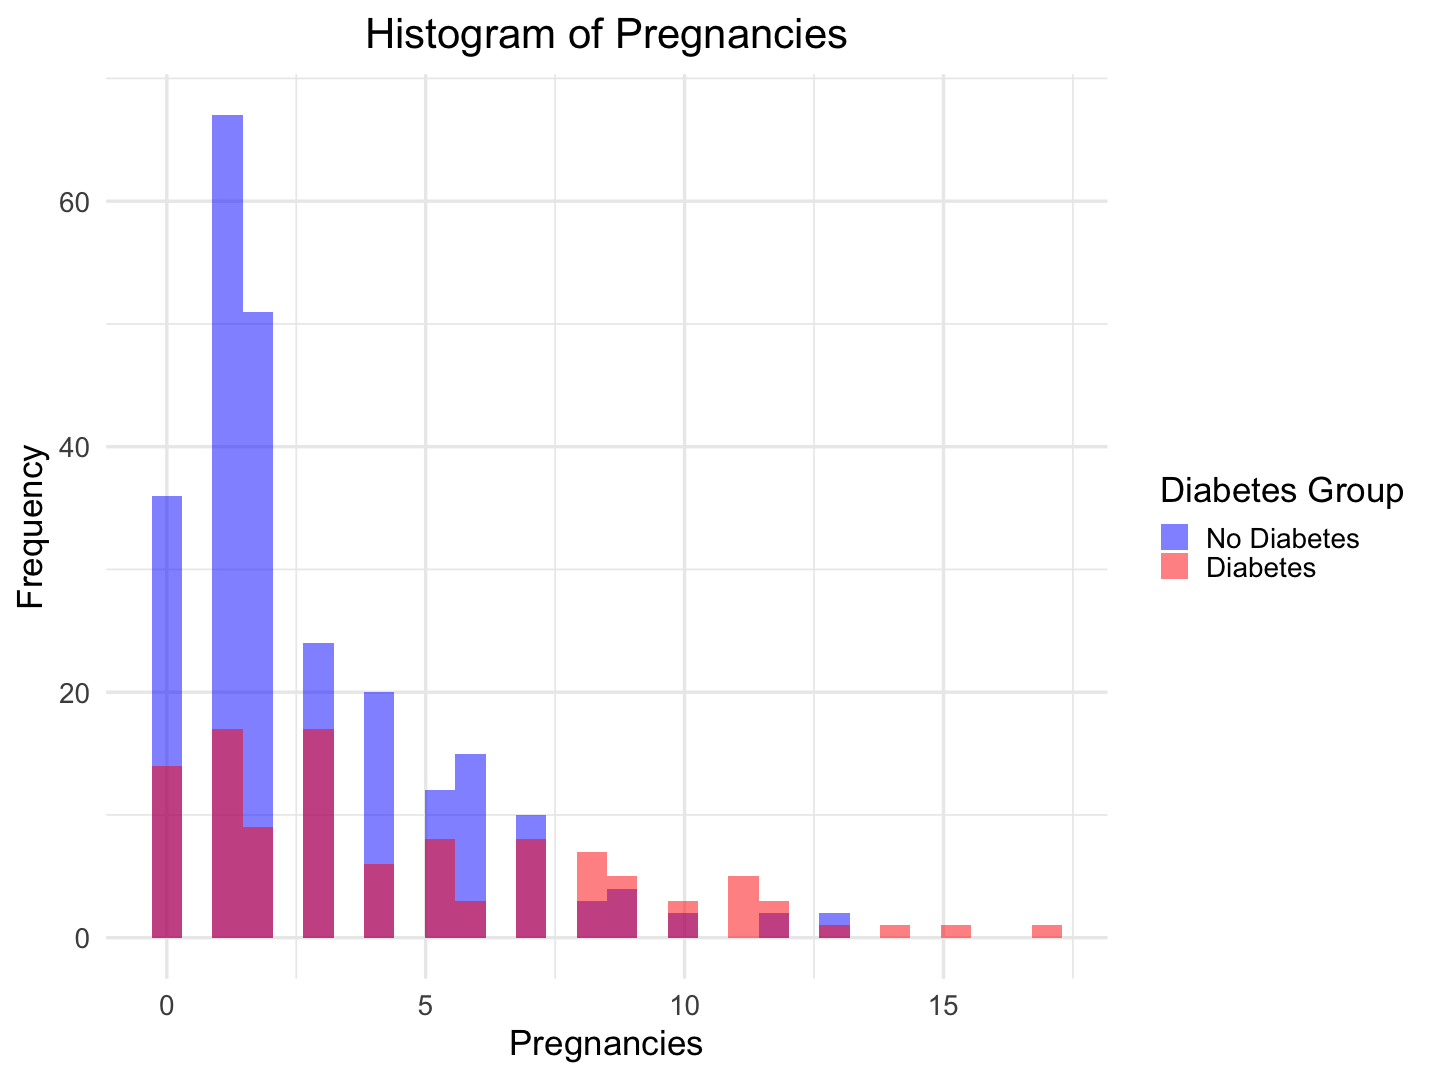

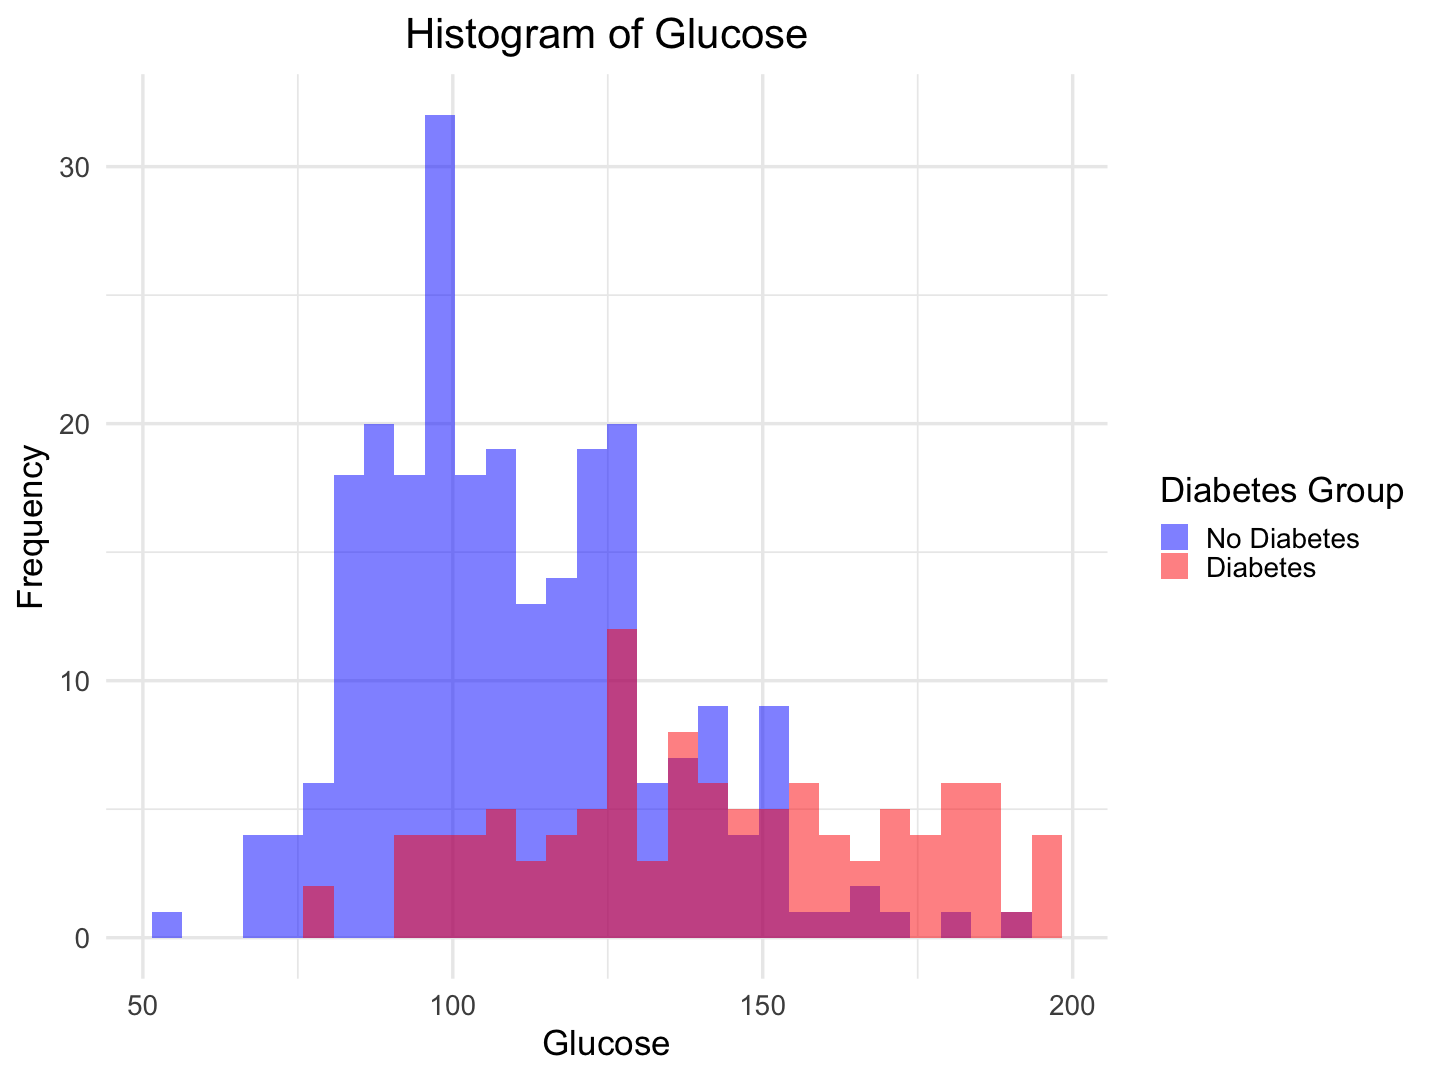

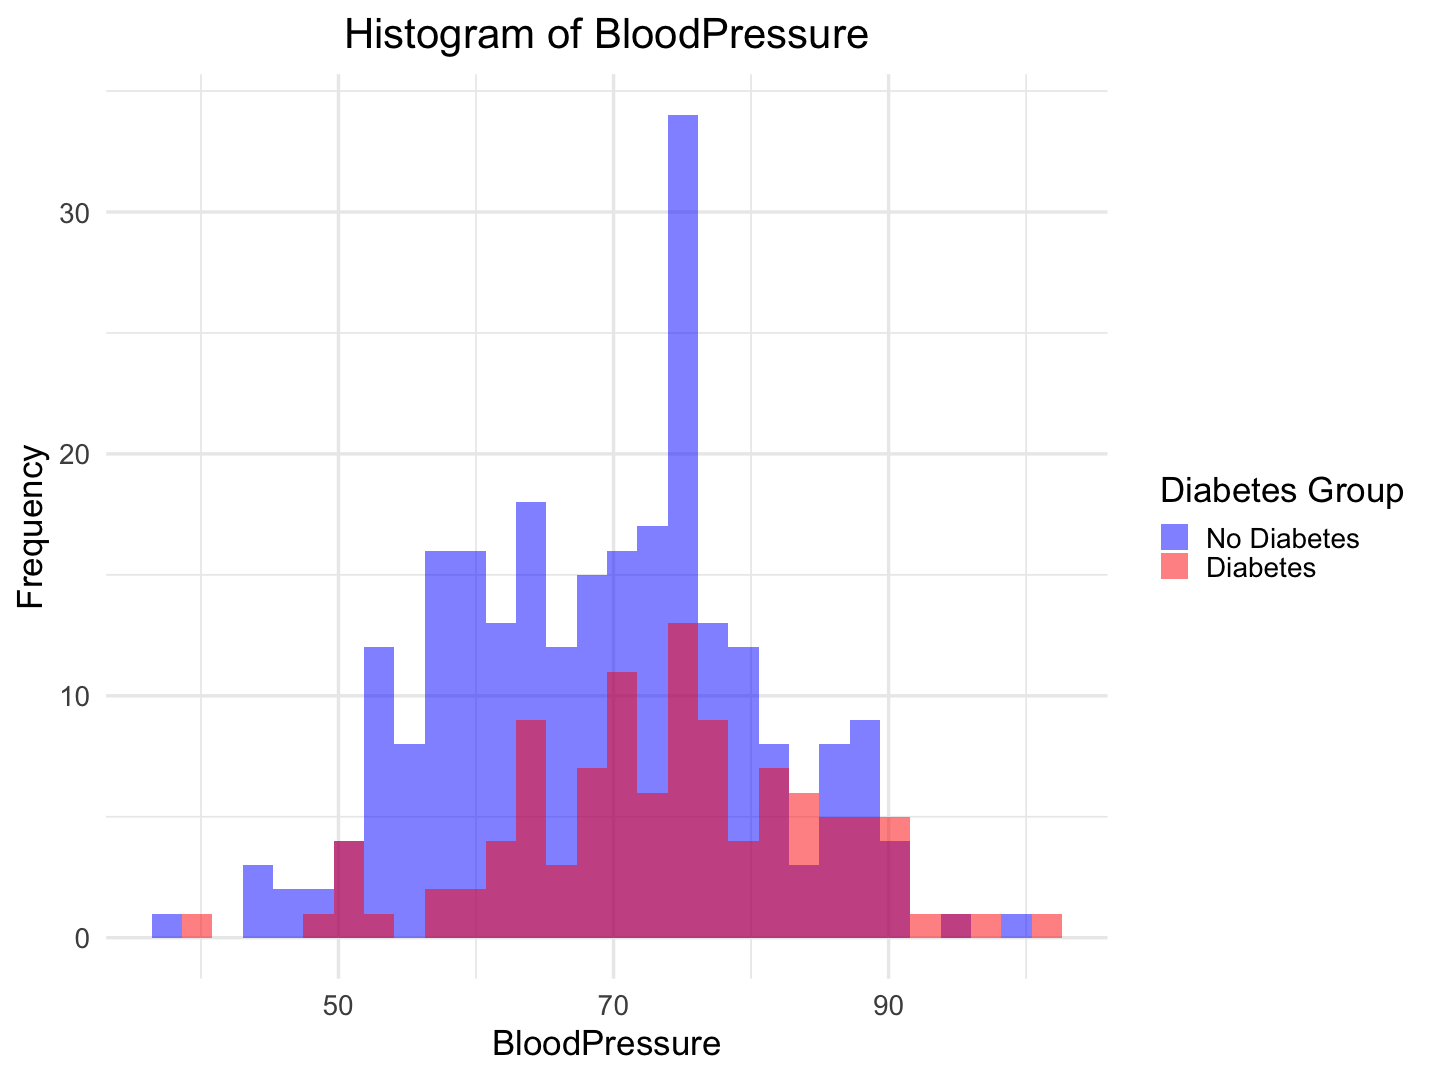

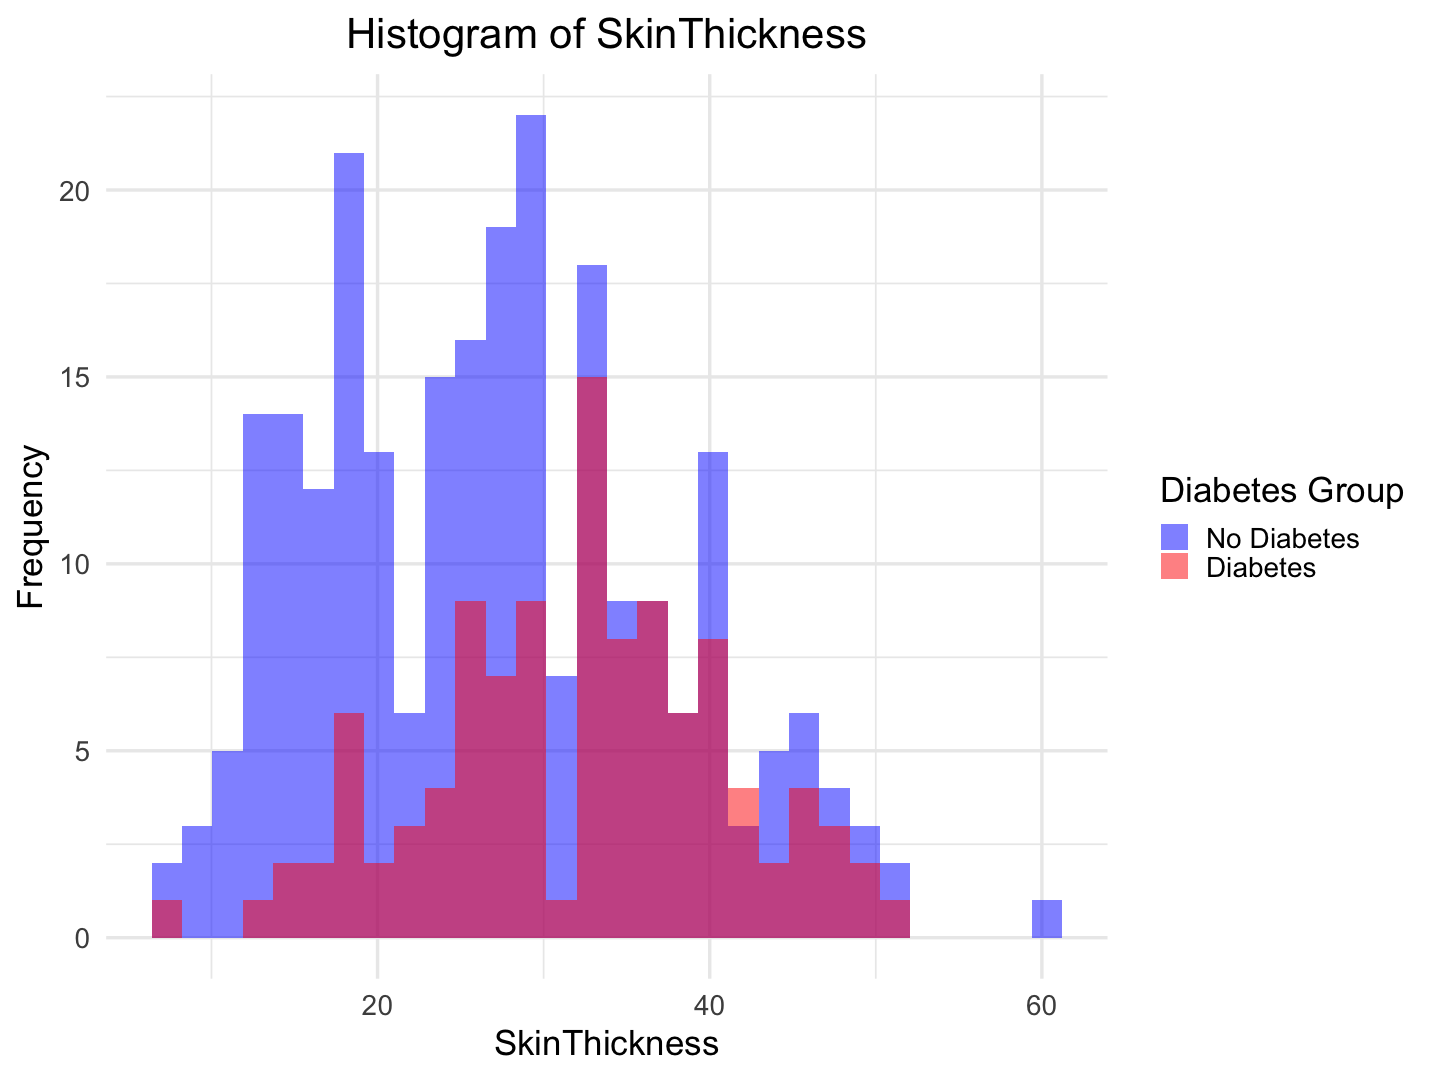

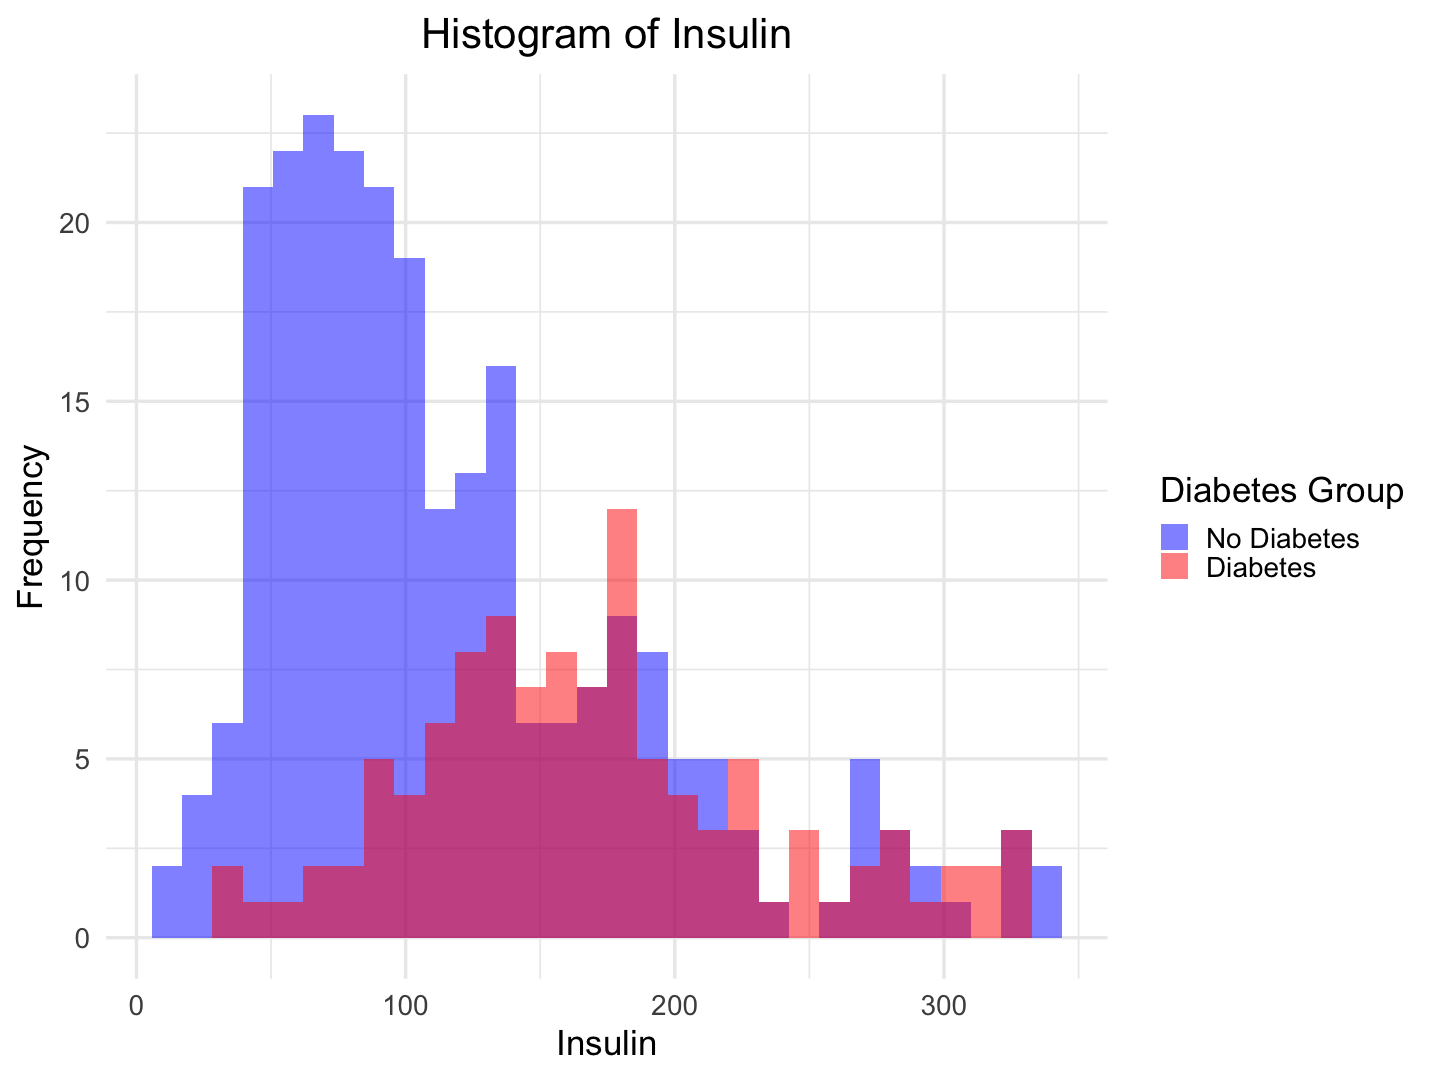

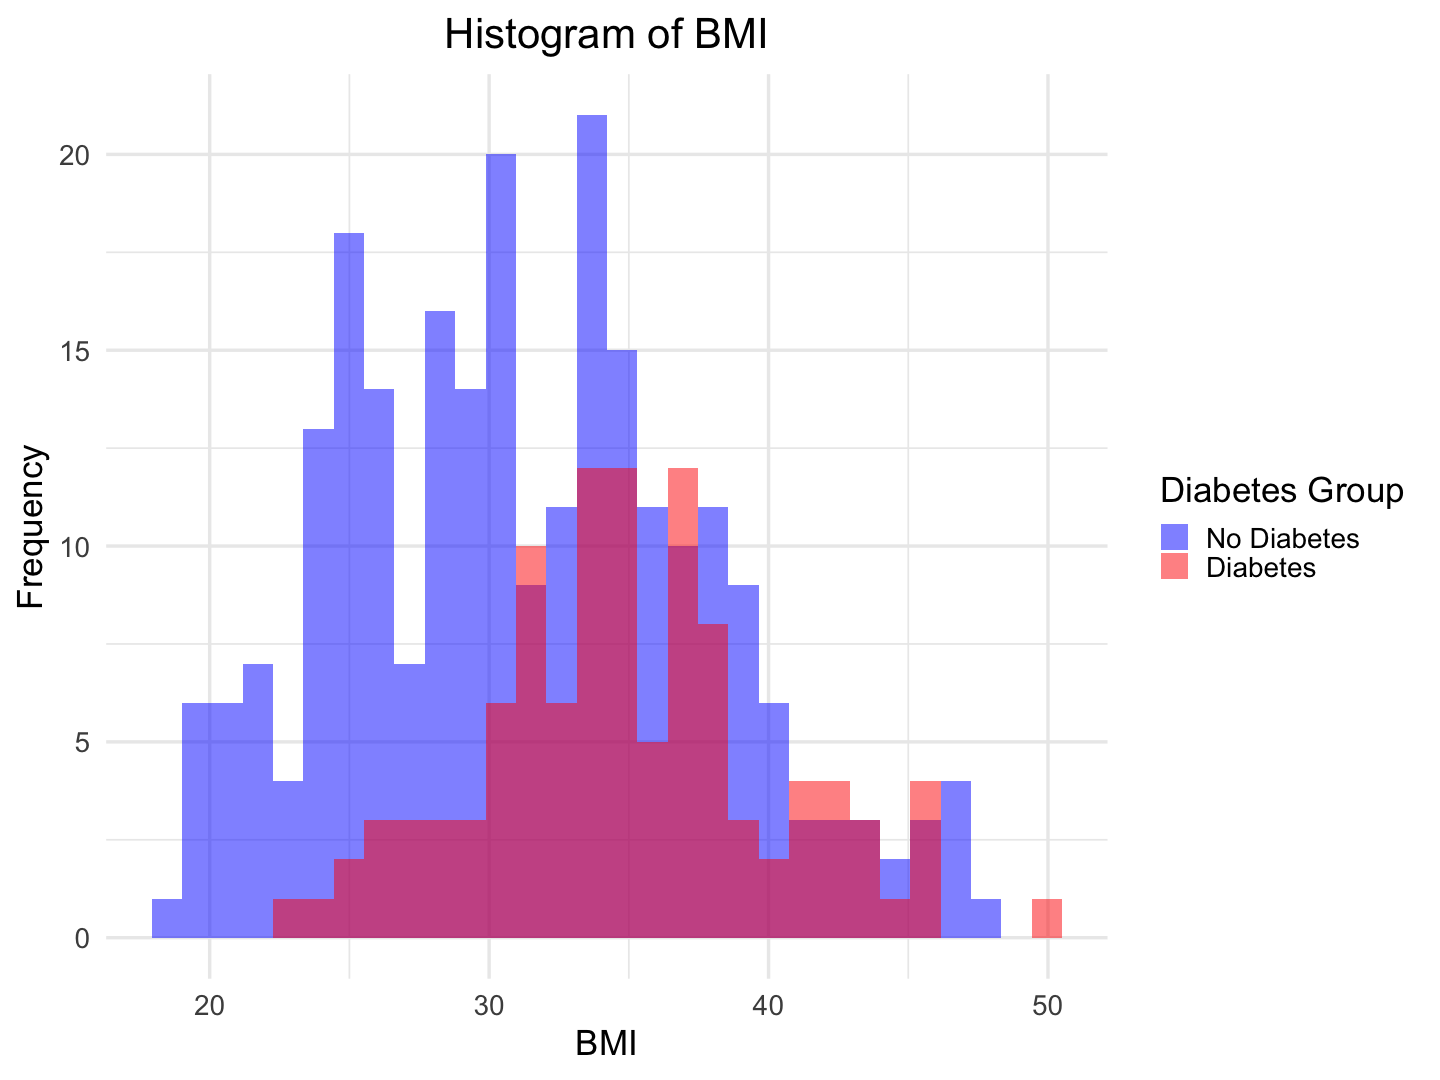

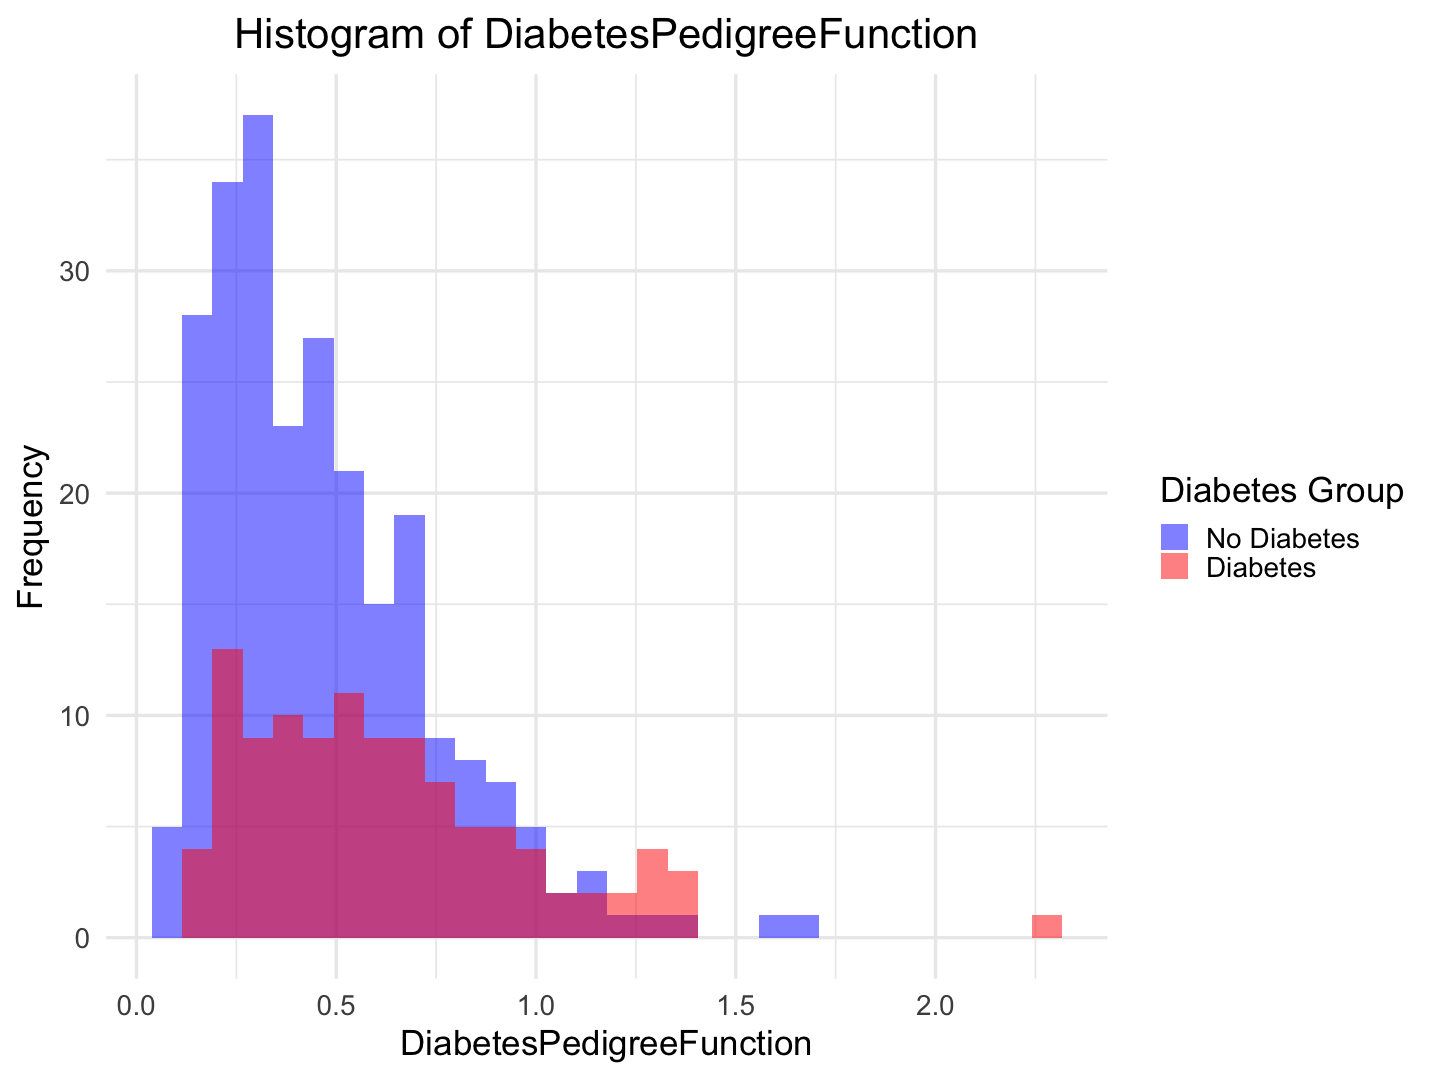

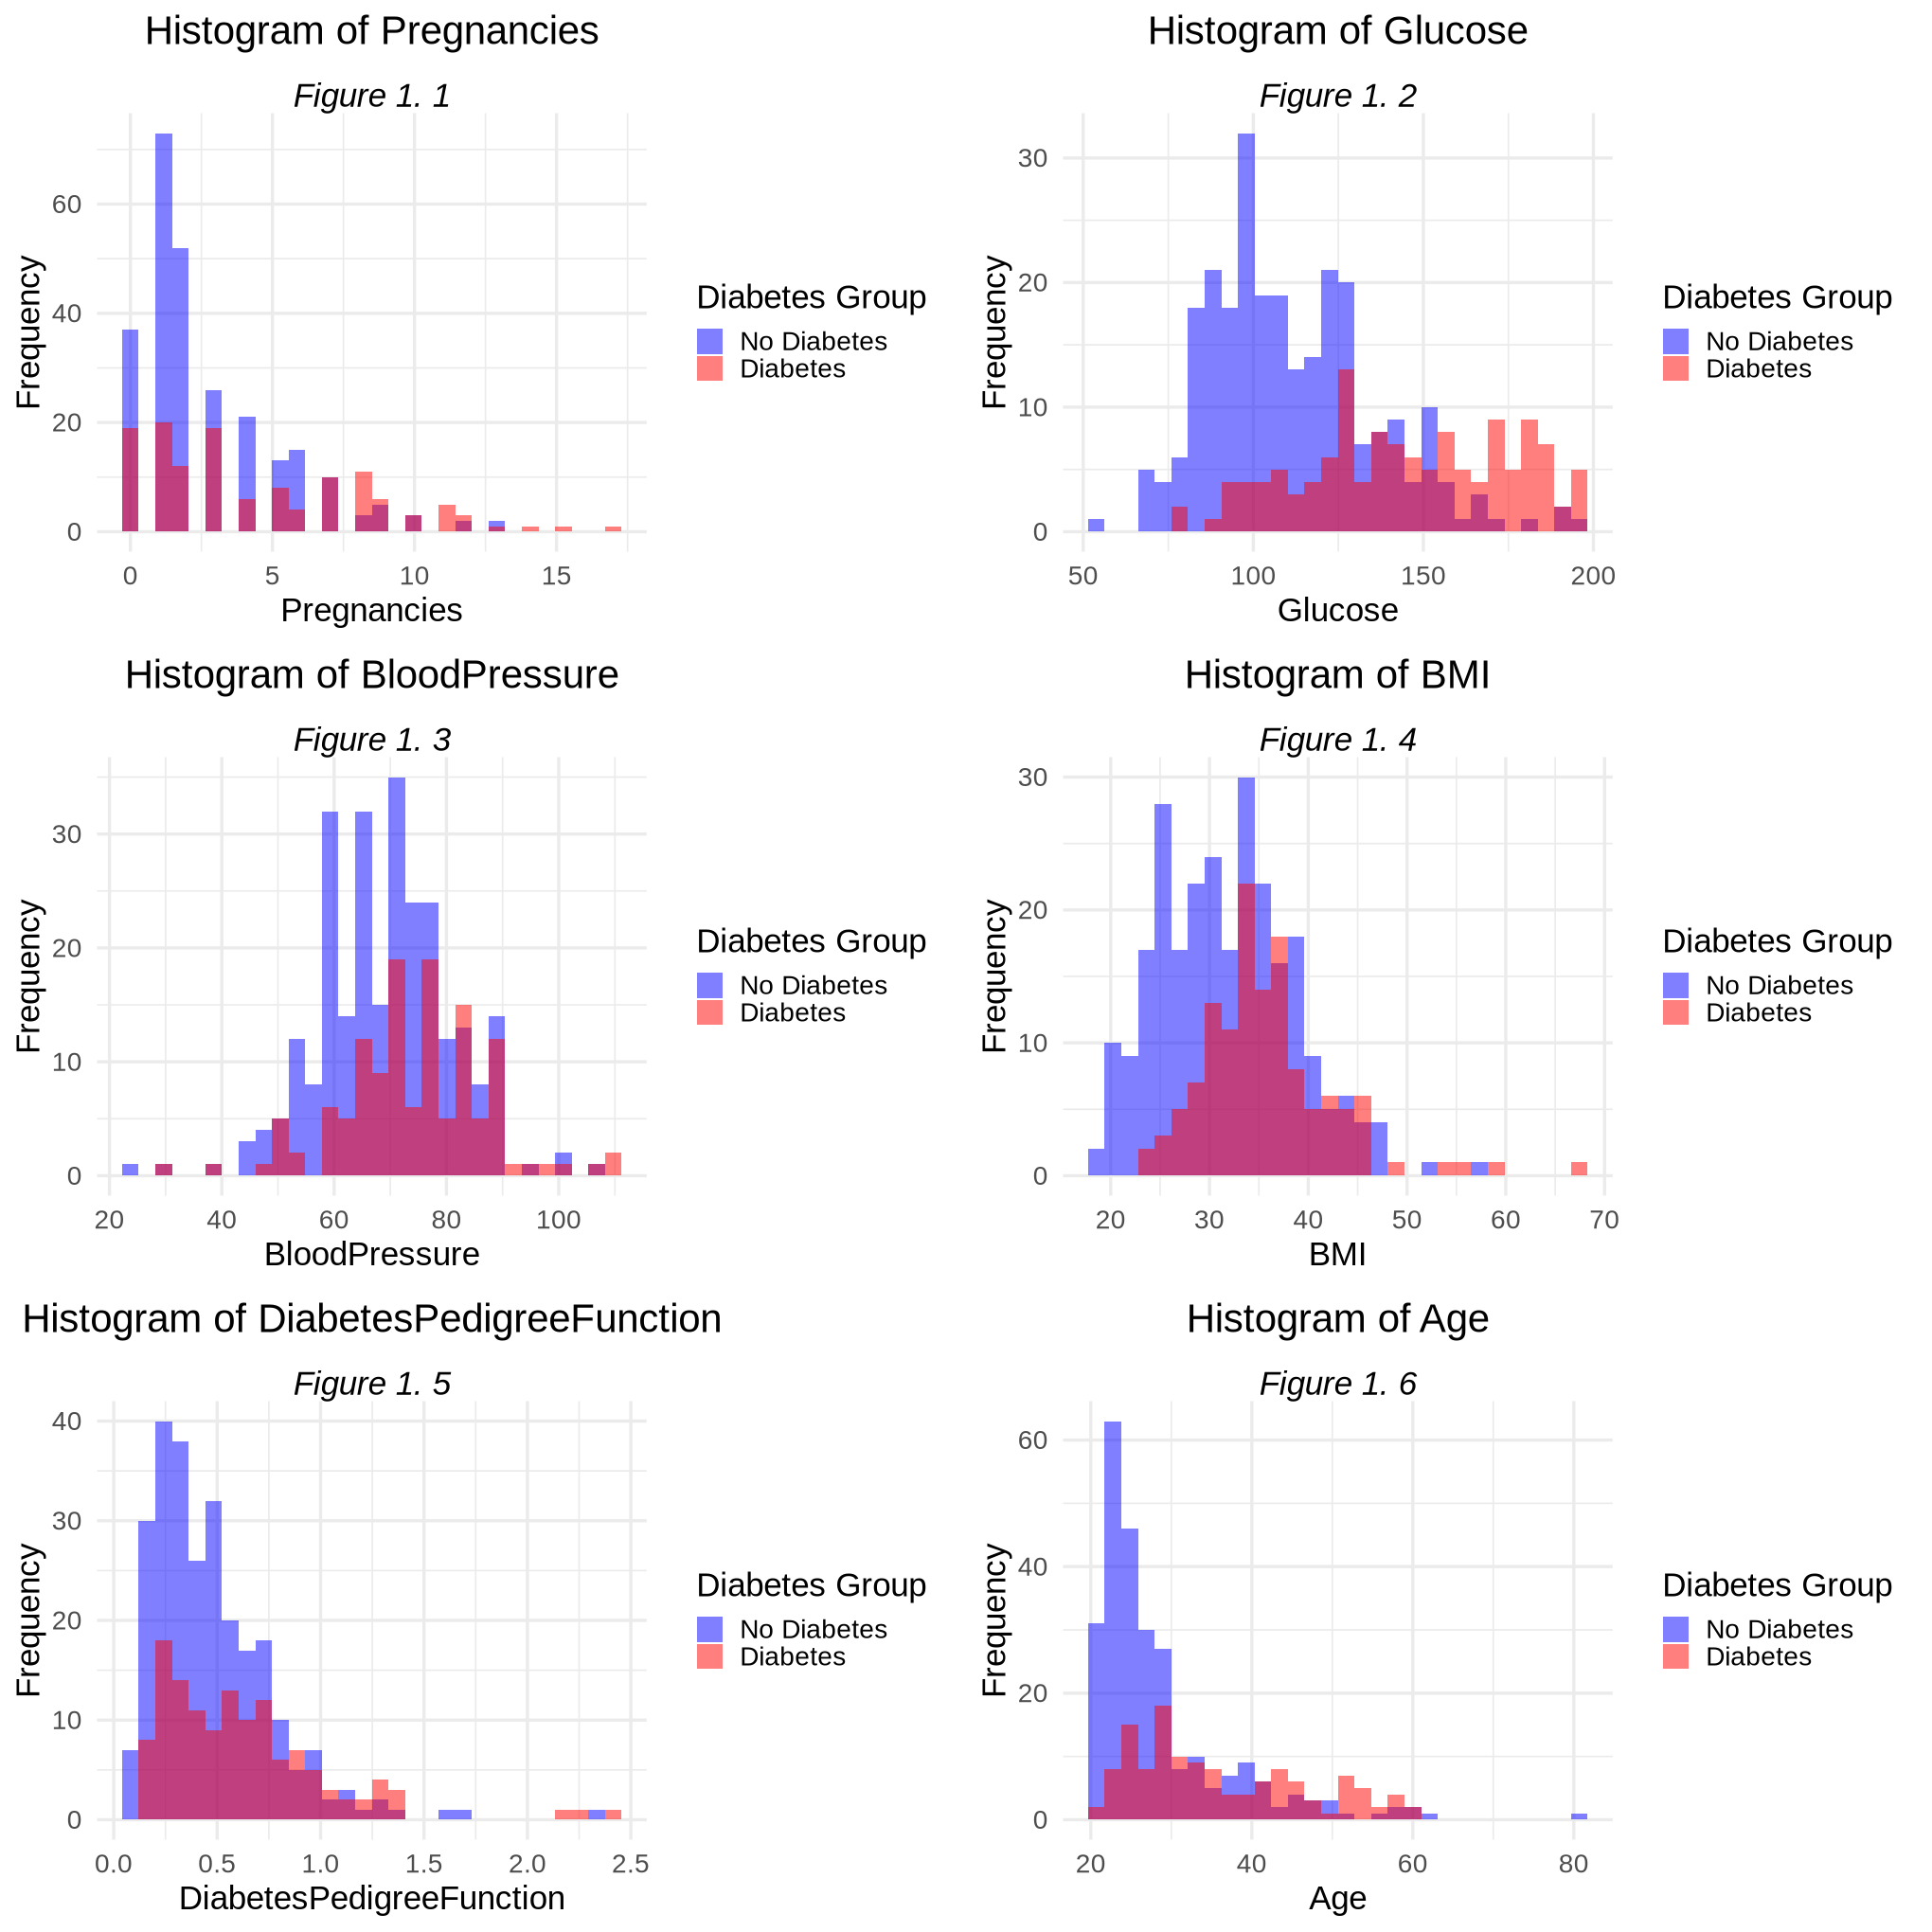

>>>>>>> remote


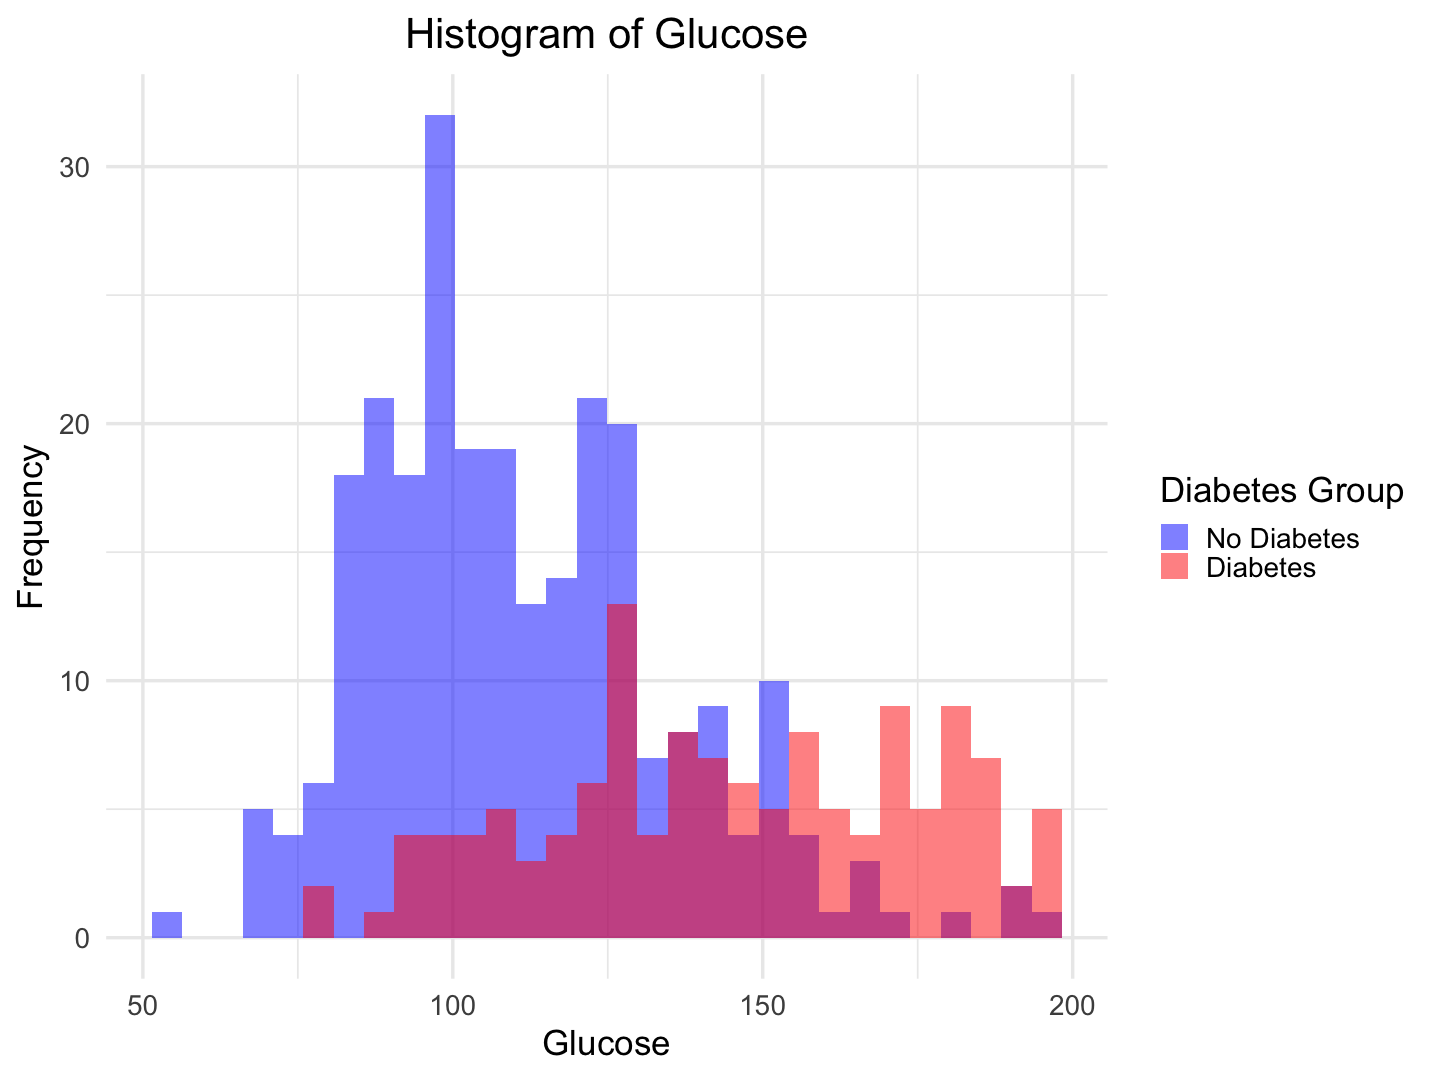

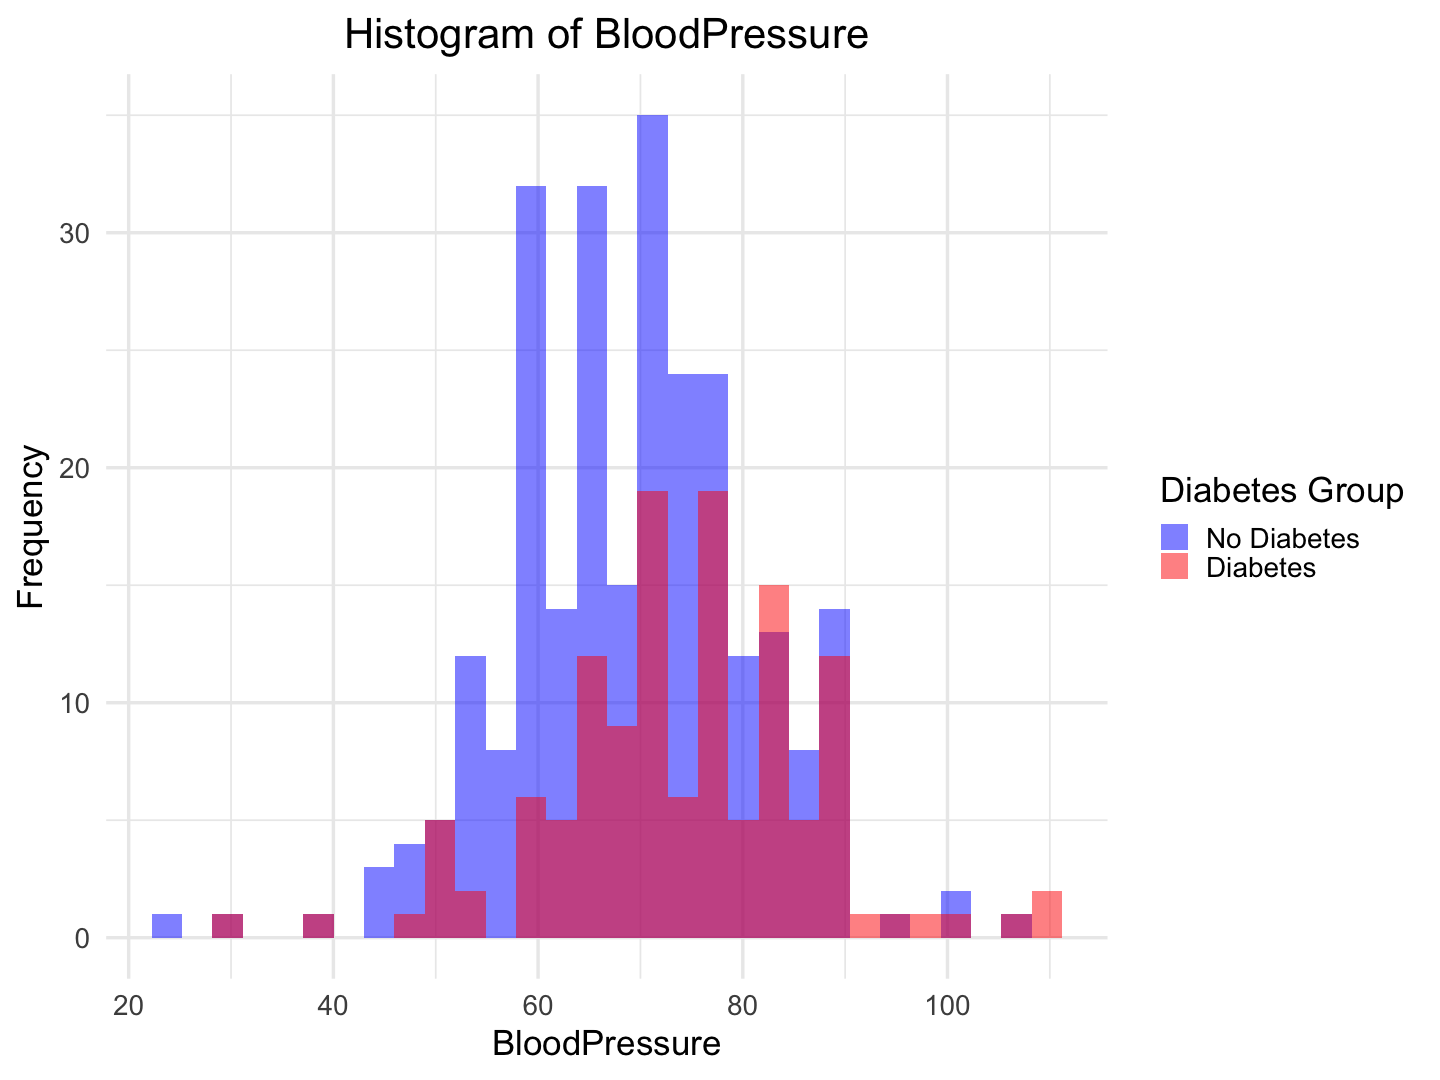

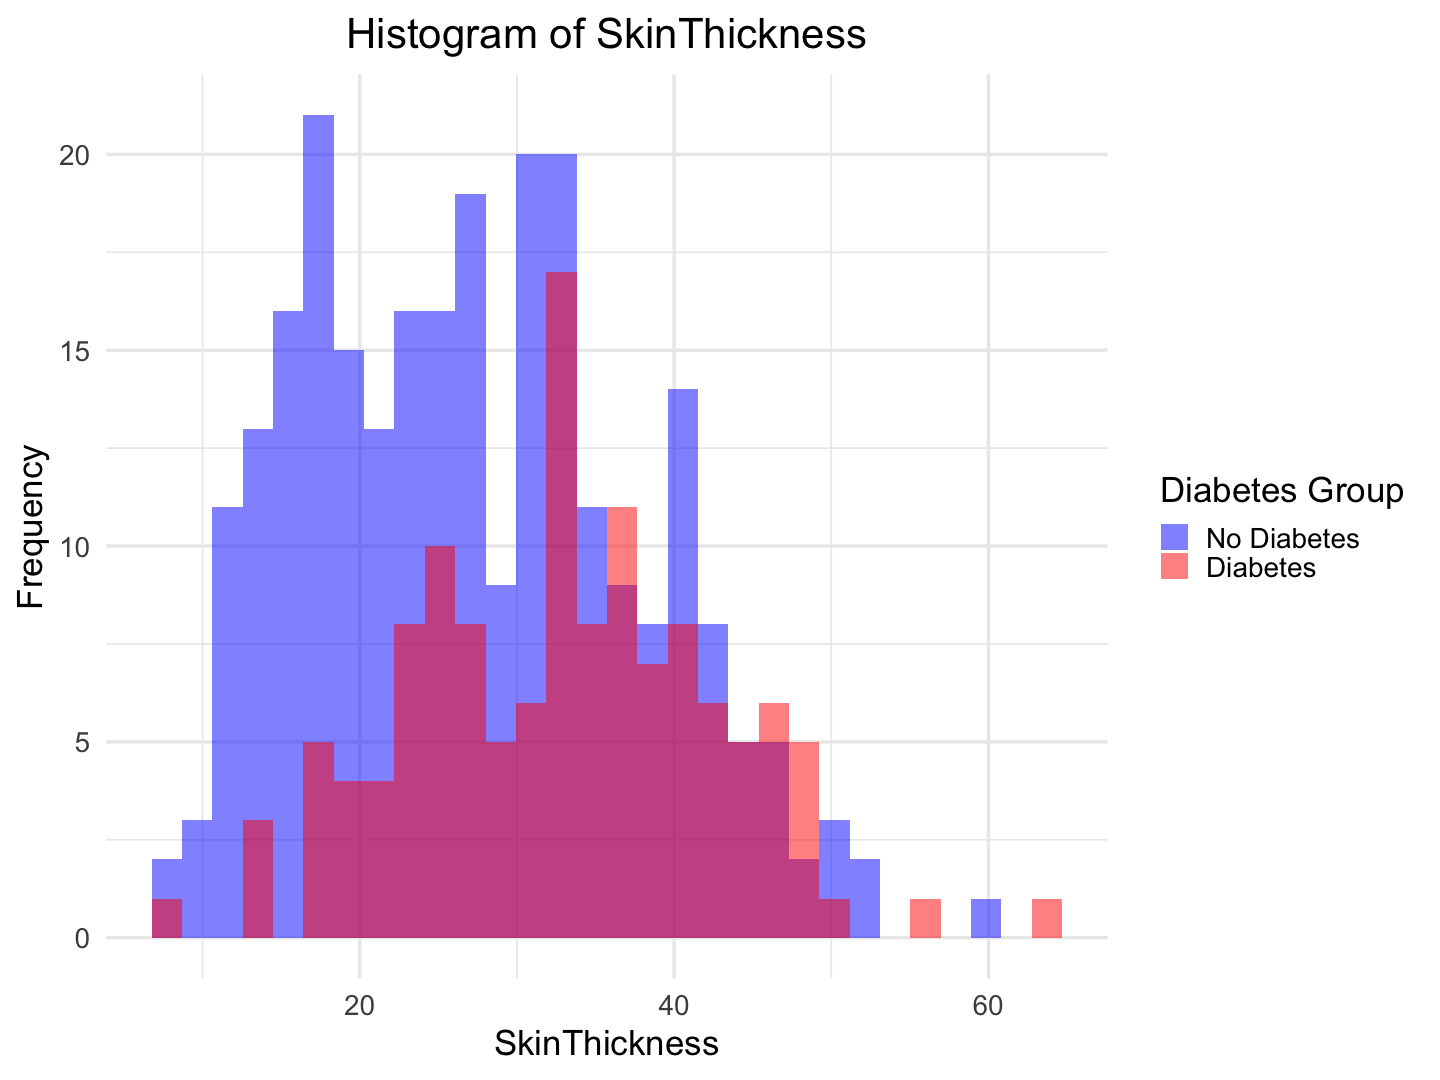

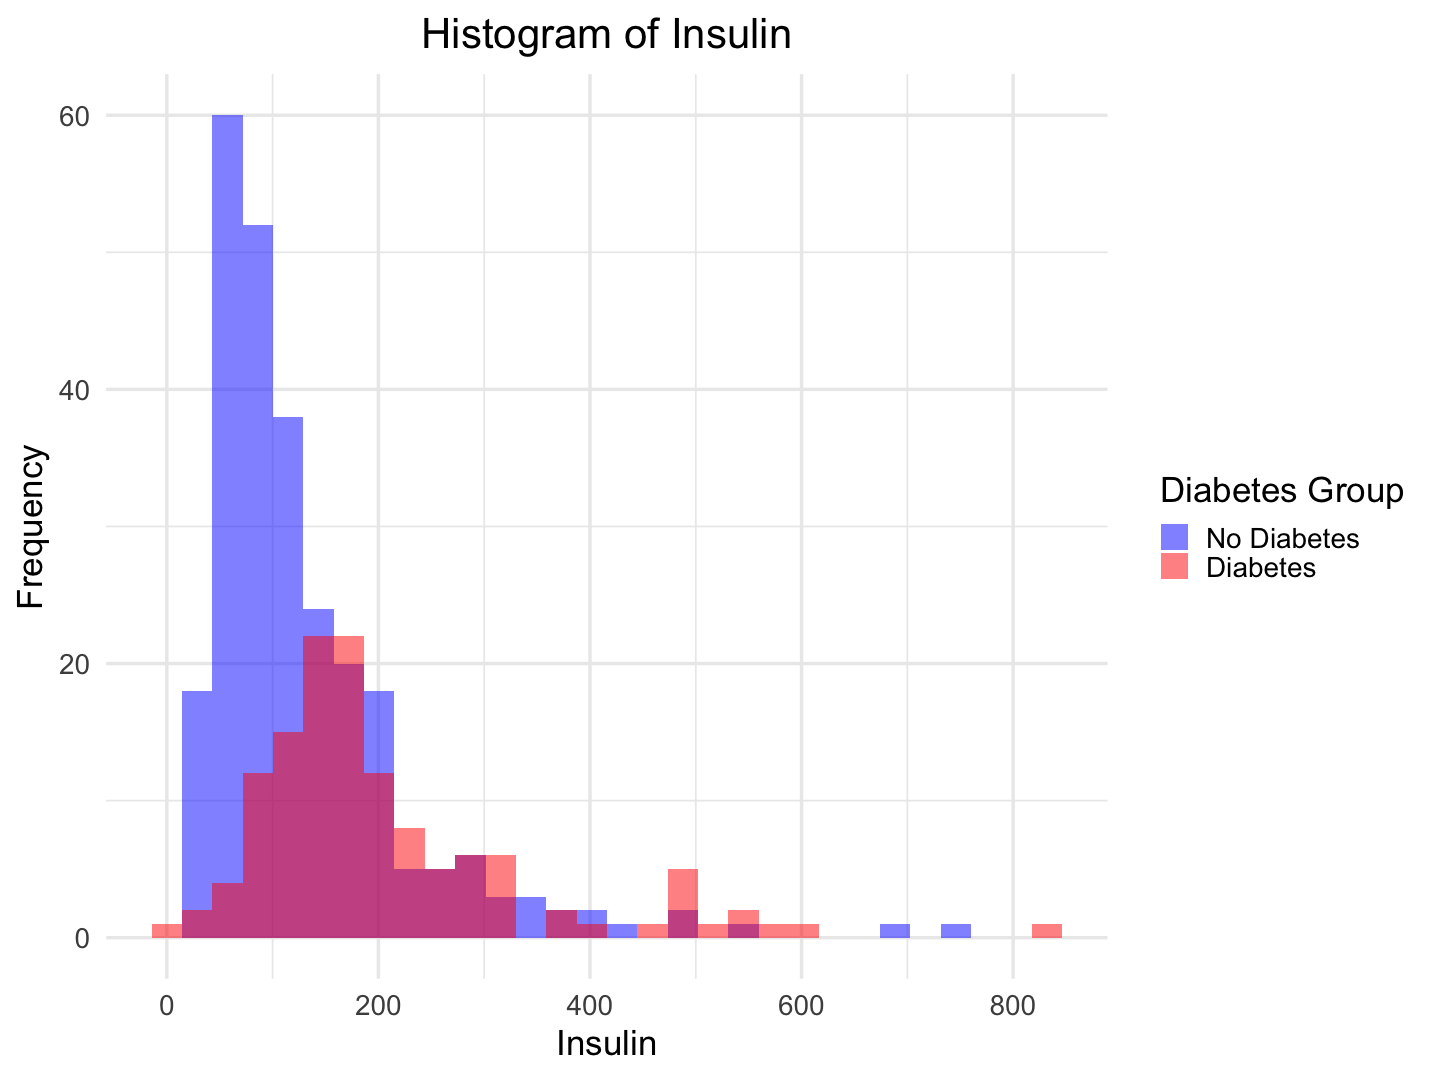

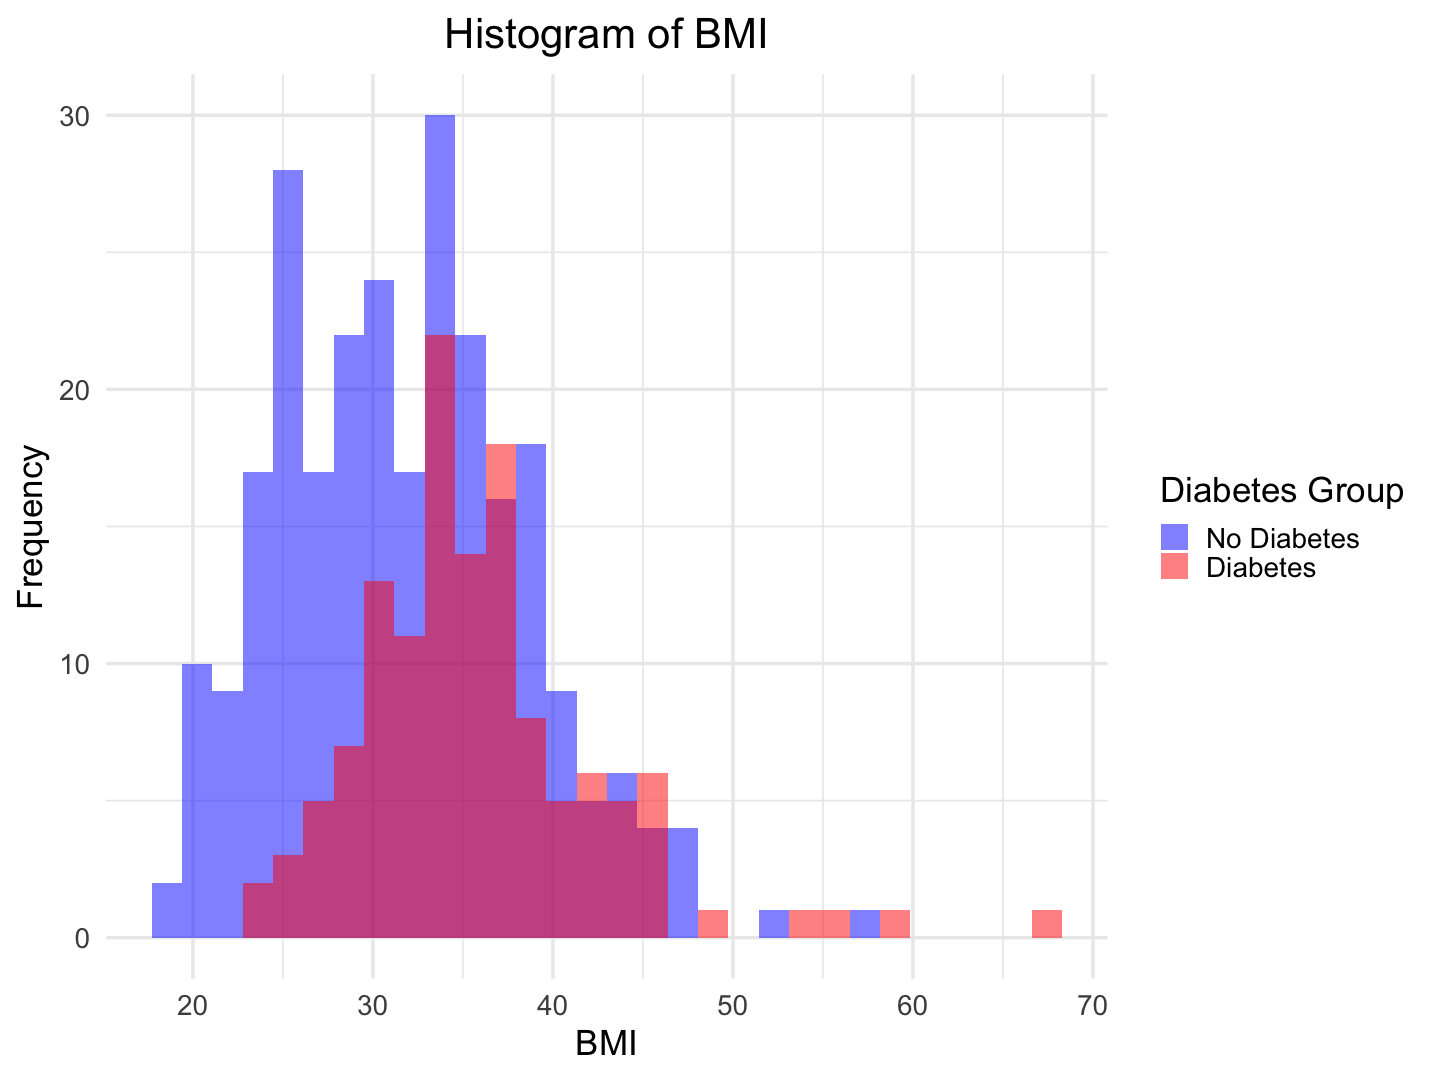

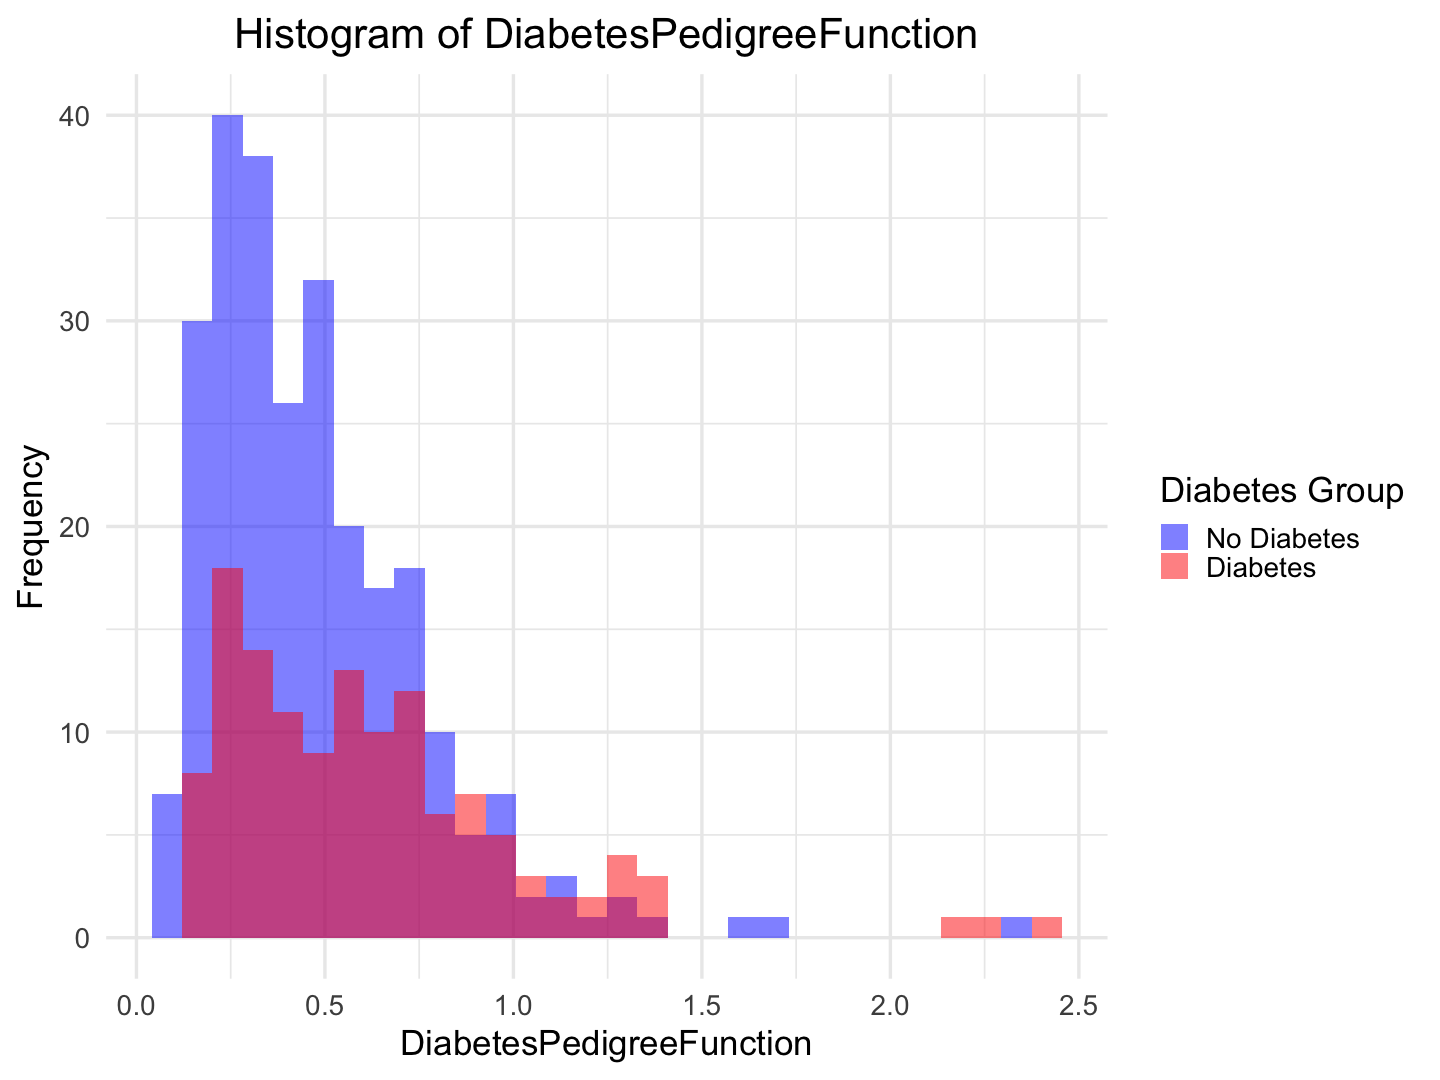

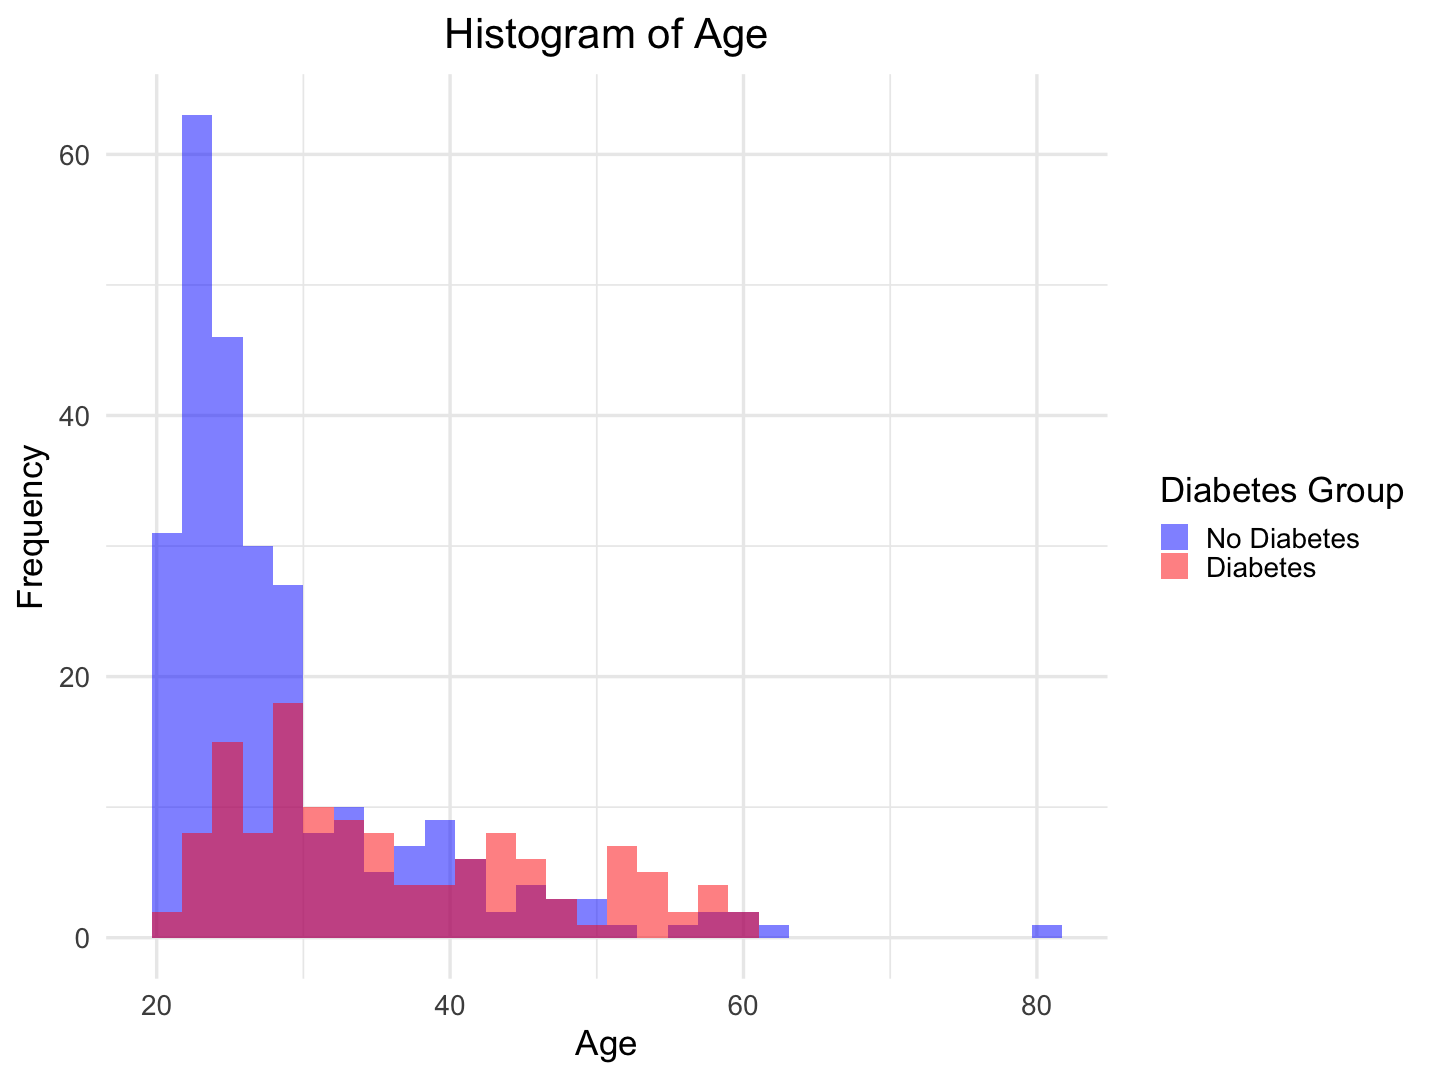

In [ ]:
# Main developer: Yulin 
options(repr.plot.width = 12, repr.plot.height = 9)

numeric_cols <- c("Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age")

for (feat in numeric_cols) {
  feat_plot <- ggplot(diabetes_cleaned) + 
    geom_histogram(aes(x = get(feat), fill = Outcome), bins = 30, alpha = 0.5, position = "identity") +
    labs(title = paste("Histogram of", feat), x = feat, y = "Frequency") +
    scale_fill_manual(values = c("blue", "red"), labels = c("No Diabetes", "Diabetes")) +
    guides(fill = guide_legend(title = "Diabetes Group")) +
    theme_minimal(base_size = 21) + 
    theme(plot.title = element_text(hjust = 0.5))
  
  print(feat_plot)
}

## Methods: Plan

In [ ]:
set.seed(123)

diabetes_sample <-
    diabetes_cleaned %>%
    mutate(id = row_number())

training_diabetes <- 
    diabetes_sample %>%
    slice_sample(prop = 0.70)

testing_diabetes <- 
    diabetes_sample %>% 
    anti_join(training_diabetes, by = "id") %>%
    select(-id)

training_diabetes <-
    training_diabetes |>
    select(-id)

[1] 2.4583333 0.4067797 2.4583333 2.4583333 0.4067797 0.4067797

In [ ]:
# Main developer: Yulin 

set.seed(123)

diabetes_X_train <- model.matrix(object = Outcome ~ .,
  data = training_diabetes)[, -1]

diabetes_Y_train <- as.matrix(training_diabetes[, "Outcome"])

diabetes_X_test <- model.matrix(object = Outcome ~ .,
  data = testing_diabetes)[, -1]

diabetes_Y_test <- as.matrix(testing_diabetes[, "Outcome"])

In [ ]:
set.seed(123)

diabetes_logistic_model <- 
    glm(
        formula = Outcome ~ .,
        data = training_diabetes,
        family = binomial)

ROC_full_log <- 
    roc(
        response = training_diabetes$Outcome, 
        predictor = predict(diabetes_logistic_model, type = "response"))

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = training_diabetes$Outcome, predictor = predict(diabetes_logistic_model,     type = "response"))

Data: predict(diabetes_logistic_model, type = "response") in 177 controls (training_diabetes$Outcome 0) < 72 cases (training_diabetes$Outcome 1).
Area under the curve: 0.8684

In [ ]:
# Main developer: Yulin 

set.seed(123)

num.folds <- 10
folds <- createFolds(training_diabetes$Outcome, k = num.folds)

auc.cv <- numeric(num.folds)

for (fold in 1:num.folds) {
  train_data <- training_diabetes[-folds[[fold]], ]
  test_data <- training_diabetes[folds[[fold]], ]
  
  model <- glm(Outcome ~ ., data = train_data, family = "binomial")
  
  predictions <- predict(model, newdata = test_data, type = "response")
  
  auc.cv[fold] <- roc(test_data$Outcome, predictions)$auc
}

diabetes_cv_ordinary <- round(mean(auc.cv), 7)

cat("Cross-validation AUC for the ordinary logistic model:", 
diabetes_cv_ordinary)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Cross-validation AUC for the ordinary logistic model: 0.8581874

In [ ]:
# Main developer: Yulin 

diabetes_AUC_models <- 
    tibble(
        model = "ordinary",
        auc = diabetes_cv_ordinary)

diabetes_AUC_models

model    auc      
1 ordinary 0.8581874

In [ ]:
# Main developer: Yulin 

set.seed(123)

diabetes_cv_lambda_ridge <- 
    cv.glmnet(
        x = diabetes_X_train, 
        y = diabetes_Y_train,
        alpha = 0,
        family = "binomial",
        weights = weights,
        type.measure = "auc",
        nfolds = 10)

diabetes_cv_lambda_ridge


Call:  cv.glmnet(x = diabetes_X_train, y = diabetes_Y_train, weights = weights,      type.measure = "auc", nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

    Lambda Index Measure      SE Nonzero
min   0.05    91  0.8254 0.03623       8
1se 197.60     2  0.8126 0.04508       8

In [ ]:
# Main developer: Yulin 

diabetes_cv_lambda_max_AUC_ridge <- round(diabetes_cv_lambda_ridge$lambda.min, 4)
diabetes_cv_lambda_1se_AUC_ridge <- round(diabetes_cv_lambda_ridge$lambda.1se, 4)

print(paste("The lambda_min in Ridge Regression:", diabetes_cv_lambda_max_AUC_ridge))
print(paste("The lambda_1se in Ridge Regression:", diabetes_cv_lambda_1se_AUC_ridge))

[1] "The lambda_min in Ridge Regression: 0.0501"
[1] "The lambda_1se in Ridge Regression: 197.596"


In [ ]:
# Main developer: Yulin 

set.seed(123)

diabetes_ridge_max_AUC <- 
    glmnet(
        x = diabetes_X_train, y = diabetes_Y_train,
        alpha = 0,
        family = "binomial",
        weights = weights,
        lambda = diabetes_cv_lambda_max_AUC_ridge)

diabetes_ridge_1se_AUC <- 
    glmnet(
        x = diabetes_X_train, y = diabetes_Y_train,
        alpha = 0,
        family = "binomial",
        weights = weights,
        lambda = diabetes_cv_lambda_1se_AUC_ridge)

coef(diabetes_ridge_max_AUC)
coef(diabetes_ridge_1se_AUC)

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)              -7.478520731
Pregnancies               0.067292007
Glucose                   0.024538186
BloodPressure             0.012379271
SkinThickness             0.007447028
Insulin                   0.003165661
BMI                       0.055684590
DiabetesPedigreeFunction  1.056561986
Age                       0.030230395

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)              8.821468e-01
Pregnancies              1.446721e-04
Glucose                  3.408961e-05
BloodPressure            3.488449e-05
SkinThickness            4.336500e-05
Insulin                  1.163695e-05
BMI                      1.001328e-04
DiabetesPedigreeFunction 1.032969e-03
Age                      7.496753e-05

In [ ]:
# Main developer: Yulin 

diabetes_AUC_models <- 
    diabetes_AUC_models %>% 
    add_row(model = "ridge_lambda_min", auc = diabetes_cv_lambda_ridge$cvm[diabetes_cv_lambda_ridge$index[1]]) |>
    add_row(model = "ridge_lambda_1se", auc = diabetes_cv_lambda_ridge$cvm[diabetes_cv_lambda_ridge$index["1se",]])

diabetes_AUC_models

model            auc      
1 ordinary         0.8581874
2 ridge_lambda_min 0.8254444
3 ridge_lambda_1se 0.8126127

In [ ]:
# Main developer: Yulin 

set.seed(123)

diabetes_cv_lambda_LASSO <- cv.glmnet(
    x = diabetes_X_train, y = diabetes_Y_train,
    alpha = 1,
    family = "binomial",
    weights = weights,
    type.measure = "auc",
    nfolds = 10
)

diabetes_cv_lambda_LASSO


Call:  cv.glmnet(x = diabetes_X_train, y = diabetes_Y_train, weights = weights,      type.measure = "auc", nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure      SE Nonzero
min 0.00694    38  0.8304 0.03464       7
1se 0.07794    12  0.7960 0.04150       3

In [ ]:
# Main developer: Yulin 

diabetes_cv_lambda_max_AUC_LASSO <- round(diabetes_cv_lambda_LASSO$lambda.min, 4)
diabetes_cv_lambda_1se_AUC_LASSO <- round(diabetes_cv_lambda_LASSO$lambda.1se, 4)

print(paste("The lambda_min in LASSO Regression:", diabetes_cv_lambda_max_AUC_LASSO))
print(paste("The lambda_1se in LASSO Regression:", diabetes_cv_lambda_1se_AUC_LASSO))

[1] "The lambda_min in LASSO Regression: 0.0069"
[1] "The lambda_1se in LASSO Regression: 0.0779"


In [ ]:
# Main developer: Yulin 

set.seed(123)

diabetes_LASSO_max_AUC <- 
    glmnet(
        x = diabetes_X_train, 
        y = diabetes_Y_train,
        alpha = 1,
        family = "binomial",
        weights = weights,
        lambda = diabetes_cv_lambda_max_AUC_LASSO)

diabetes_LASSO_1se_AUC <- 
    glmnet(
        x = diabetes_X_train, 
        y = diabetes_Y_train,
        alpha = 1,
        family = "binomial",
        weights = weights,
        lambda = diabetes_cv_lambda_1se_AUC_LASSO)

coef(diabetes_LASSO_max_AUC)
coef(diabetes_LASSO_1se_AUC)

9 x 1 sparse Matrix of class "dgCMatrix"
                                    s0
(Intercept)              -9.8080230301
Pregnancies               0.0818049944
Glucose                   0.0386713147
BloodPressure             0.0097717724
SkinThickness             .           
Insulin                   0.0004619684
BMI                       0.0865142061
DiabetesPedigreeFunction  1.5620069334
Age                       0.0318816242

9 x 1 sparse Matrix of class "dgCMatrix"
                                  s0
(Intercept)              -3.06376988
Pregnancies               .         
Glucose                   0.02161828
BloodPressure             .         
SkinThickness             .         
Insulin                   .         
BMI                       0.02105365
DiabetesPedigreeFunction  .         
Age                       0.01443170

In [ ]:
# Main developer: Yulin 

diabetes_AUC_models <- 
    diabetes_AUC_models %>% 
    add_row(model = "lasso_lambda_min", auc = diabetes_cv_lambda_LASSO$cvm[diabetes_cv_lambda_LASSO$index[1]]) |>
    add_row(model = "lasso_lambda_1se", auc = diabetes_cv_lambda_LASSO$cvm[diabetes_cv_lambda_LASSO$index["1se",]])

diabetes_AUC_models

model            auc      
1 ordinary         0.8581874
2 ridge_lambda_min 0.8254444
3 ridge_lambda_1se 0.8126127
4 lasso_lambda_min 0.8303976
5 lasso_lambda_1se 0.7959658

In [ ]:
ROC_lasso_lambda_min <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_LASSO_max_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_lasso_lambda_1se <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_LASSO_1se_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_ridge_lambda_min <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_ridge_max_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_ridge_lambda_1se <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_ridge_1se_AUC,
                      newx = diabetes_X_test)[,"s0"] )

ROC_ordinary <- roc(
  response = testing_diabetes$Outcome,
  predictor = predict(diabetes_logistic_model,
                      newdata = testing_diabetes))



Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



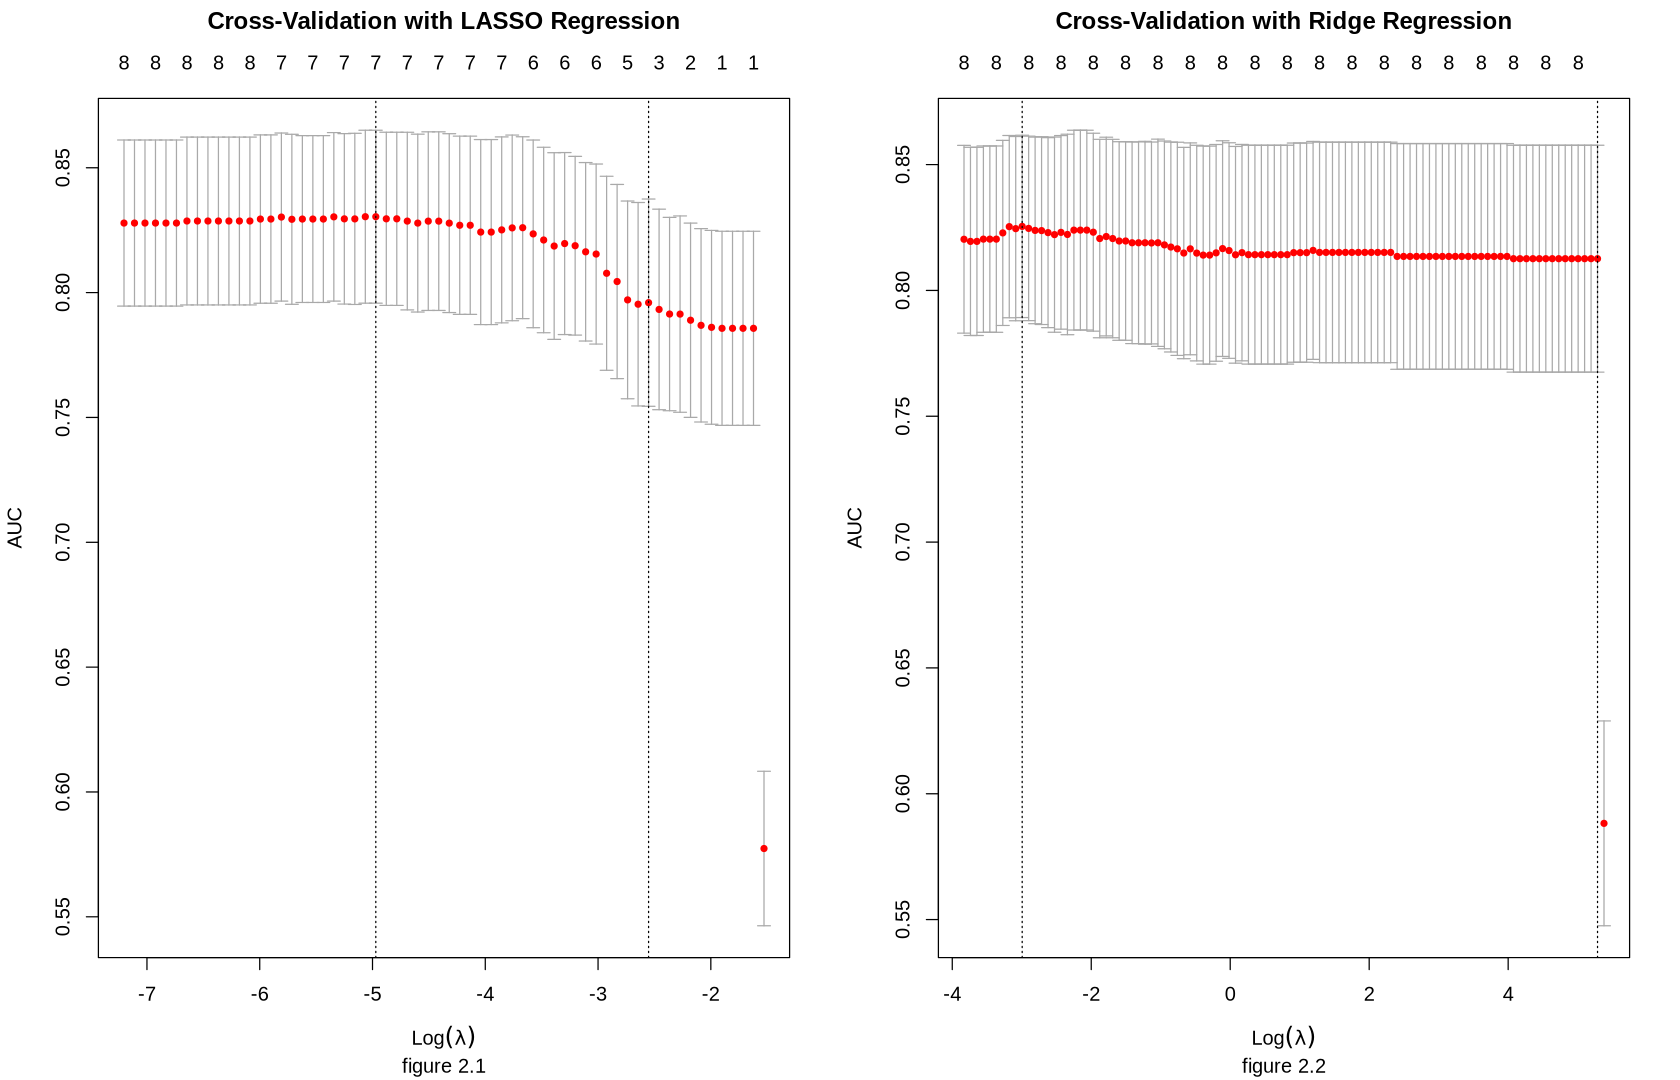

In [354]:
options(repr.plot.width = 14, repr.plot.height = 9)

par(mfrow = c(1, 2))


plot(diabetes_cv_lambda_LASSO, 
     main = "Cross-Validation with LASSO Regression\n\n",
    sub = "figure 2.1")


plot(diabetes_cv_lambda_ridge, 
     main = "Cross-Validation with Ridge Regression\n\n",
    sub = "figure 2.2")


par(mfrow = c(1, 1))

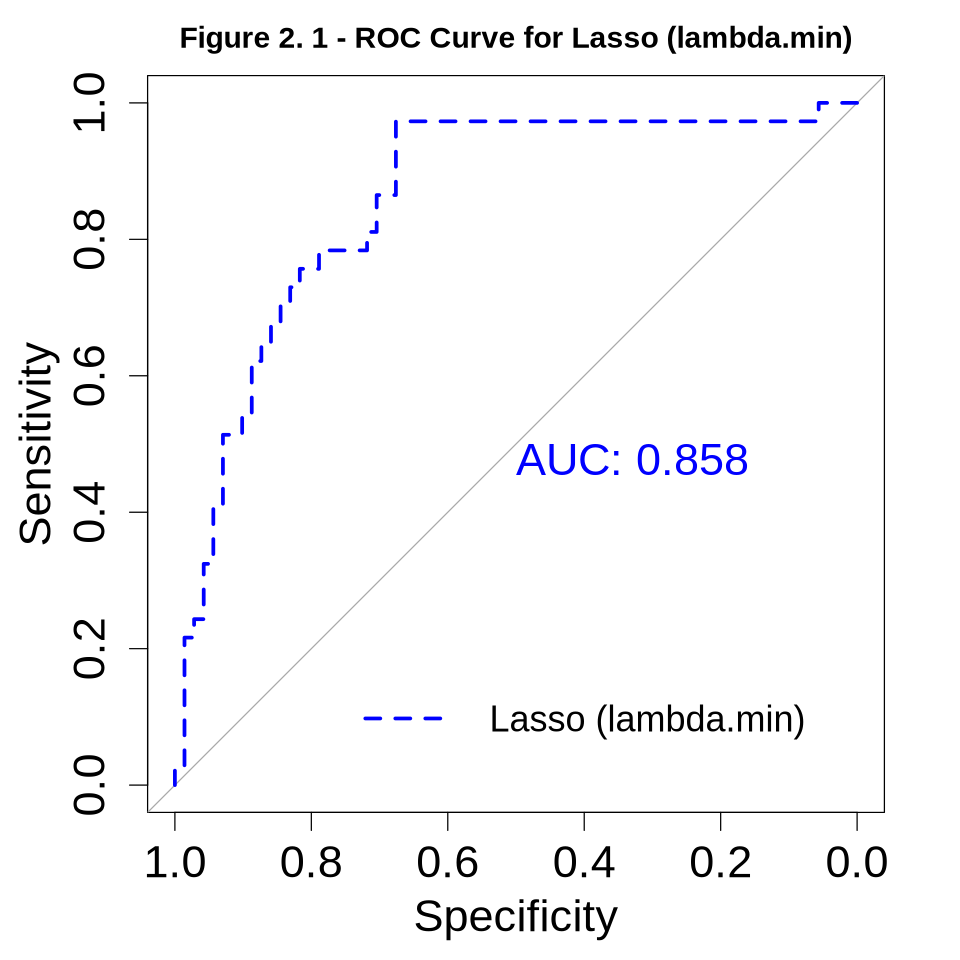

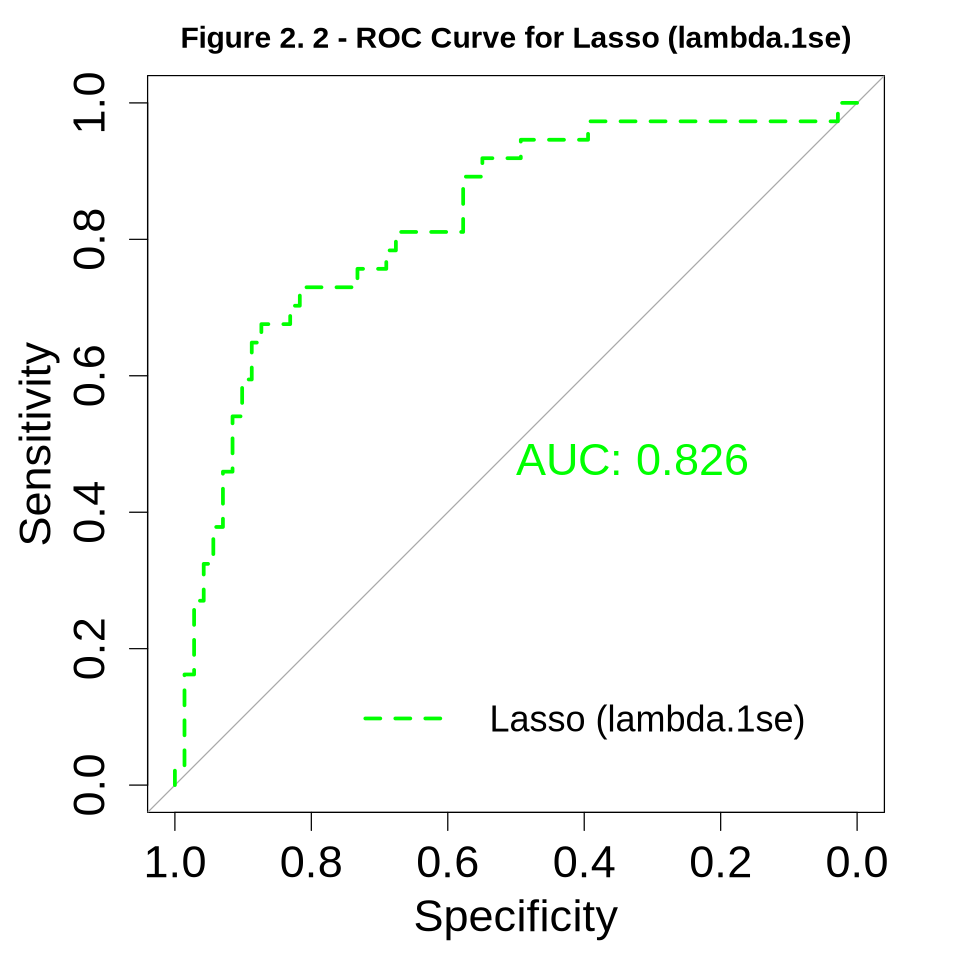

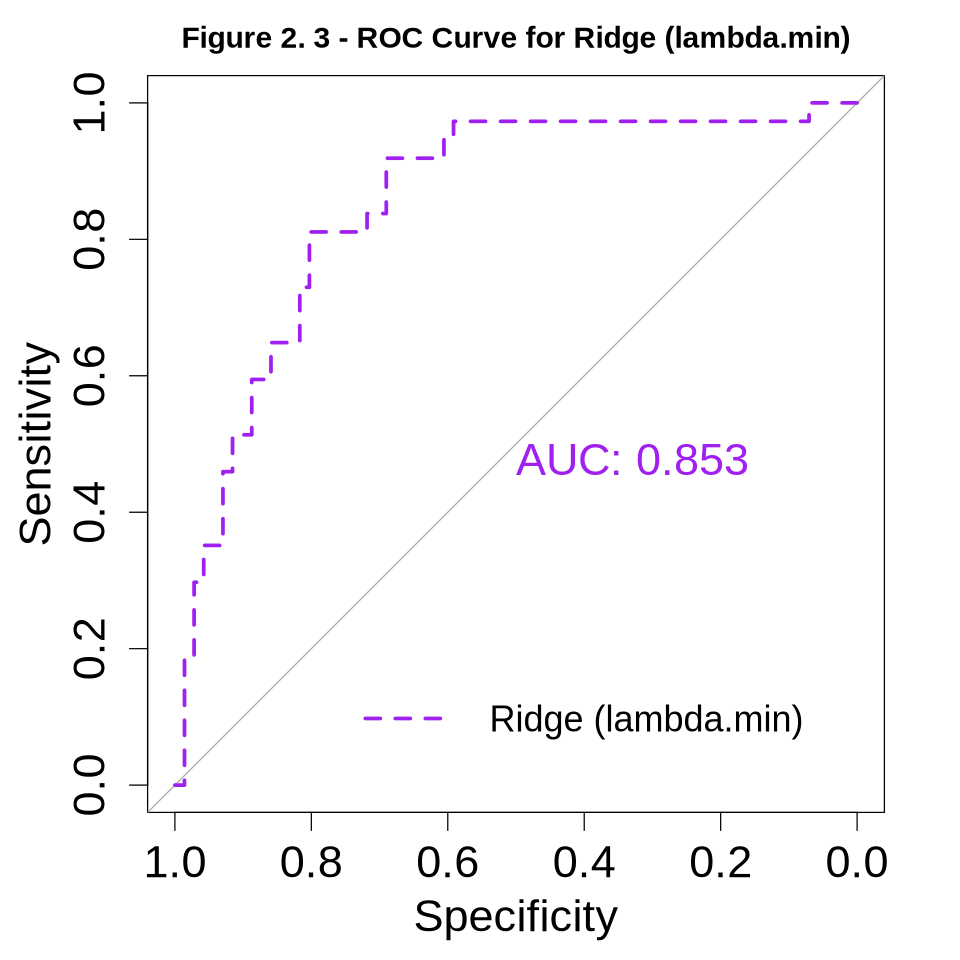

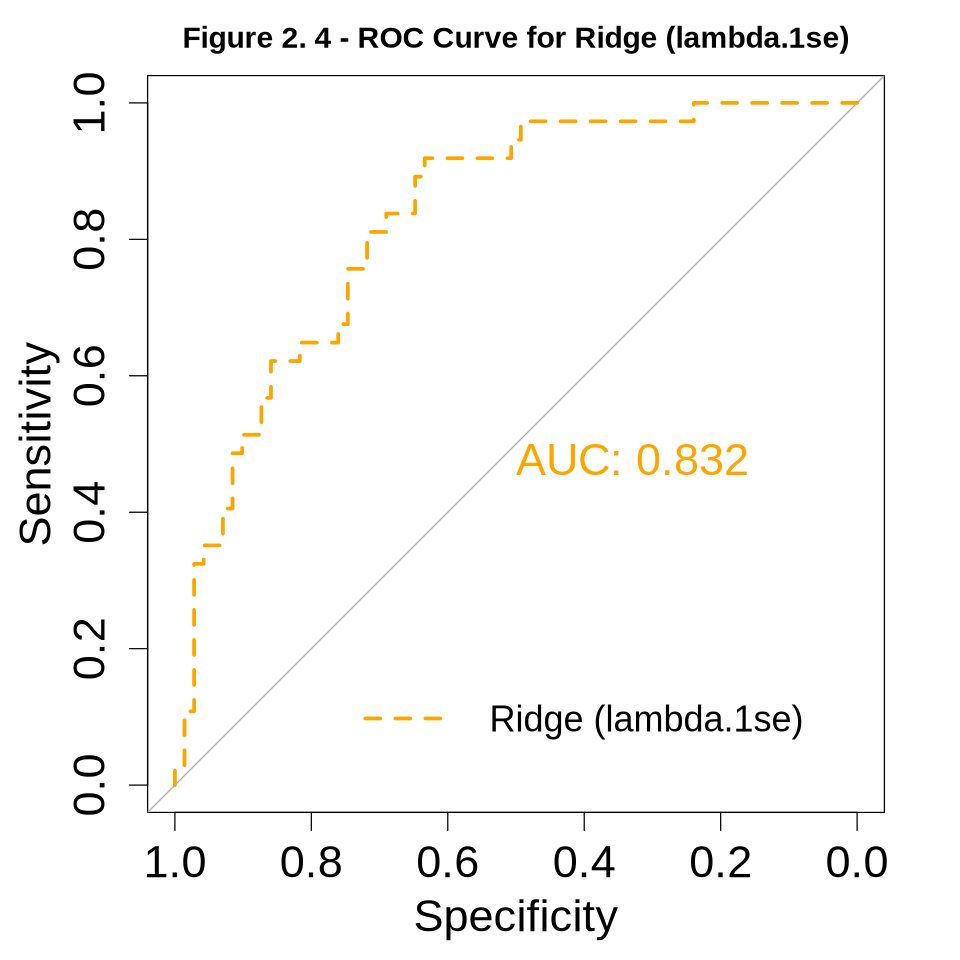

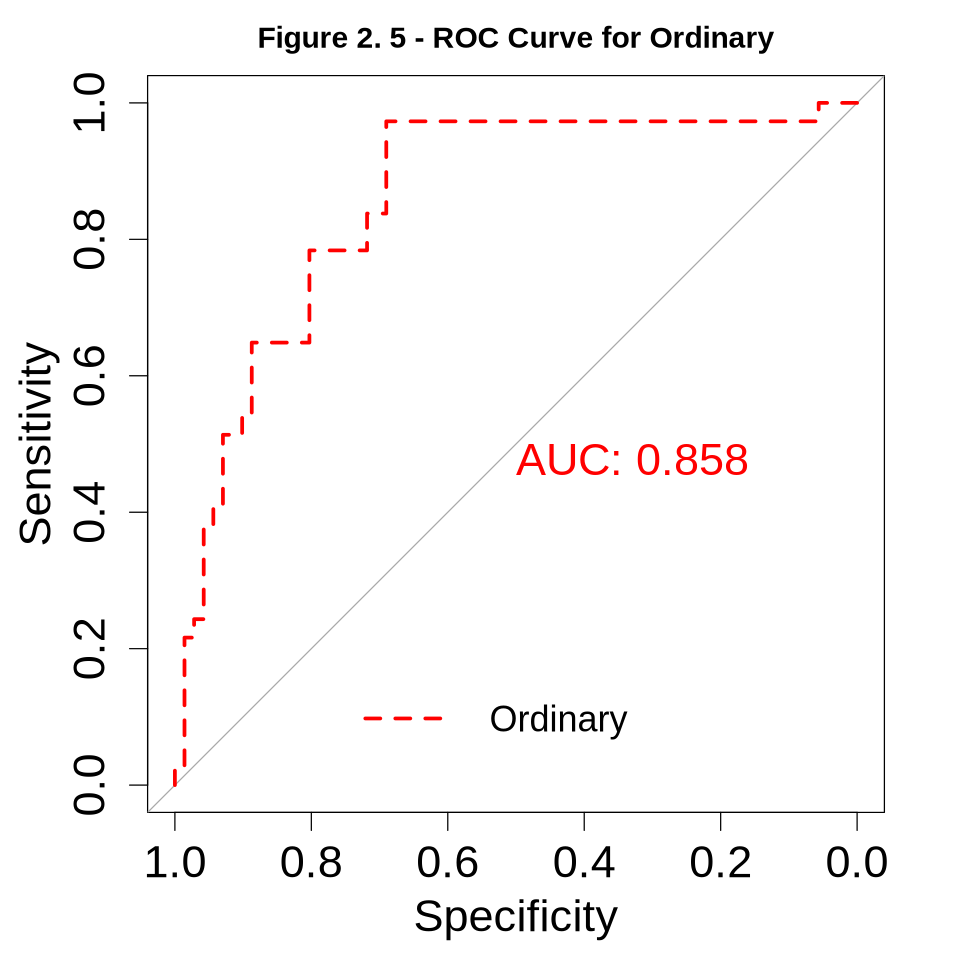

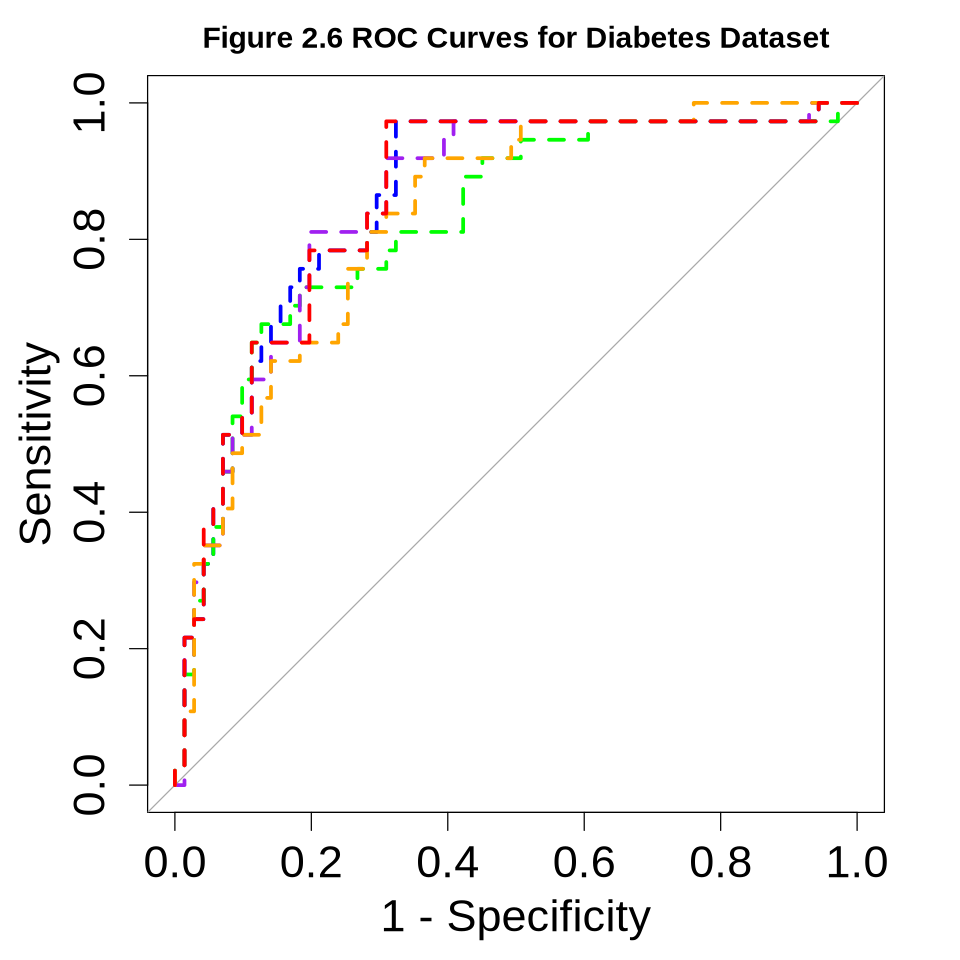

In [262]:
#Main author: Josh and Yulin
#Roc Auc Graphs
roc_models <- list(
  lasso_lambda_min = ROC_lasso_lambda_min,
  lasso_lambda_1se = ROC_lasso_lambda_1se,
  ridge_lambda_min = ROC_ridge_lambda_min,
  ridge_lambda_1se = ROC_ridge_lambda_1se,
  ordinary = ROC_ordinary
)

colors <- c(
  lasso_lambda_min = "blue",
  lasso_lambda_1se = "green",
  ridge_lambda_min = "purple",
  ridge_lambda_1se = "orange",
  ordinary = "red"
)

legends <- c(
  lasso_lambda_min = "Lasso (lambda.min)",
  lasso_lambda_1se = "Lasso (lambda.1se)",
  ridge_lambda_min = "Ridge (lambda.min)",
  ridge_lambda_1se = "Ridge (lambda.1se)",
  ordinary = "Ordinary"
)


options(repr.plot.width = 8, repr.plot.height = 8)

#for loop for each model and to add figure numbers
for (i in seq_along(roc_models)) {
  model_name <- names(roc_models)[i]
  par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1)

  plot(
    roc_models[[model_name]],
    print.auc = TRUE,
    col = colors[model_name],
    lwd = 3,
    lty = 2,
    main = paste("Figure 3.", i, "- ROC Curve for", legends[model_name])
  )
  par(fig = c(0, 1, 0, 1), new = TRUE)
  plot.new()
  legend(
    x = "bottomright",
    inset = c(-0.2, 0),
    legend = legends[model_name],
    col = colors[model_name],
    lwd = 3,
    text.width = strwidth("1,00000000000000000000000"),
    lty = 2,
    bty = "n",
    cex = 1.2,
    xpd = TRUE
  )
}
#plotting all of the roc's in one graph

plot(
  roc_models[[1]],
  col = colors[1],
  lwd = 3,
  lty = 2,
  main = "Figure 3.6 ROC Curves for Diabetes Dataset",
  legacy.axes = TRUE
)
for (i in 2:length(roc_models)) {
  plot(
    roc_models[[i]],
    col = colors[i],
    lwd = 3,
    lty = 2,
    add = TRUE
  )
}

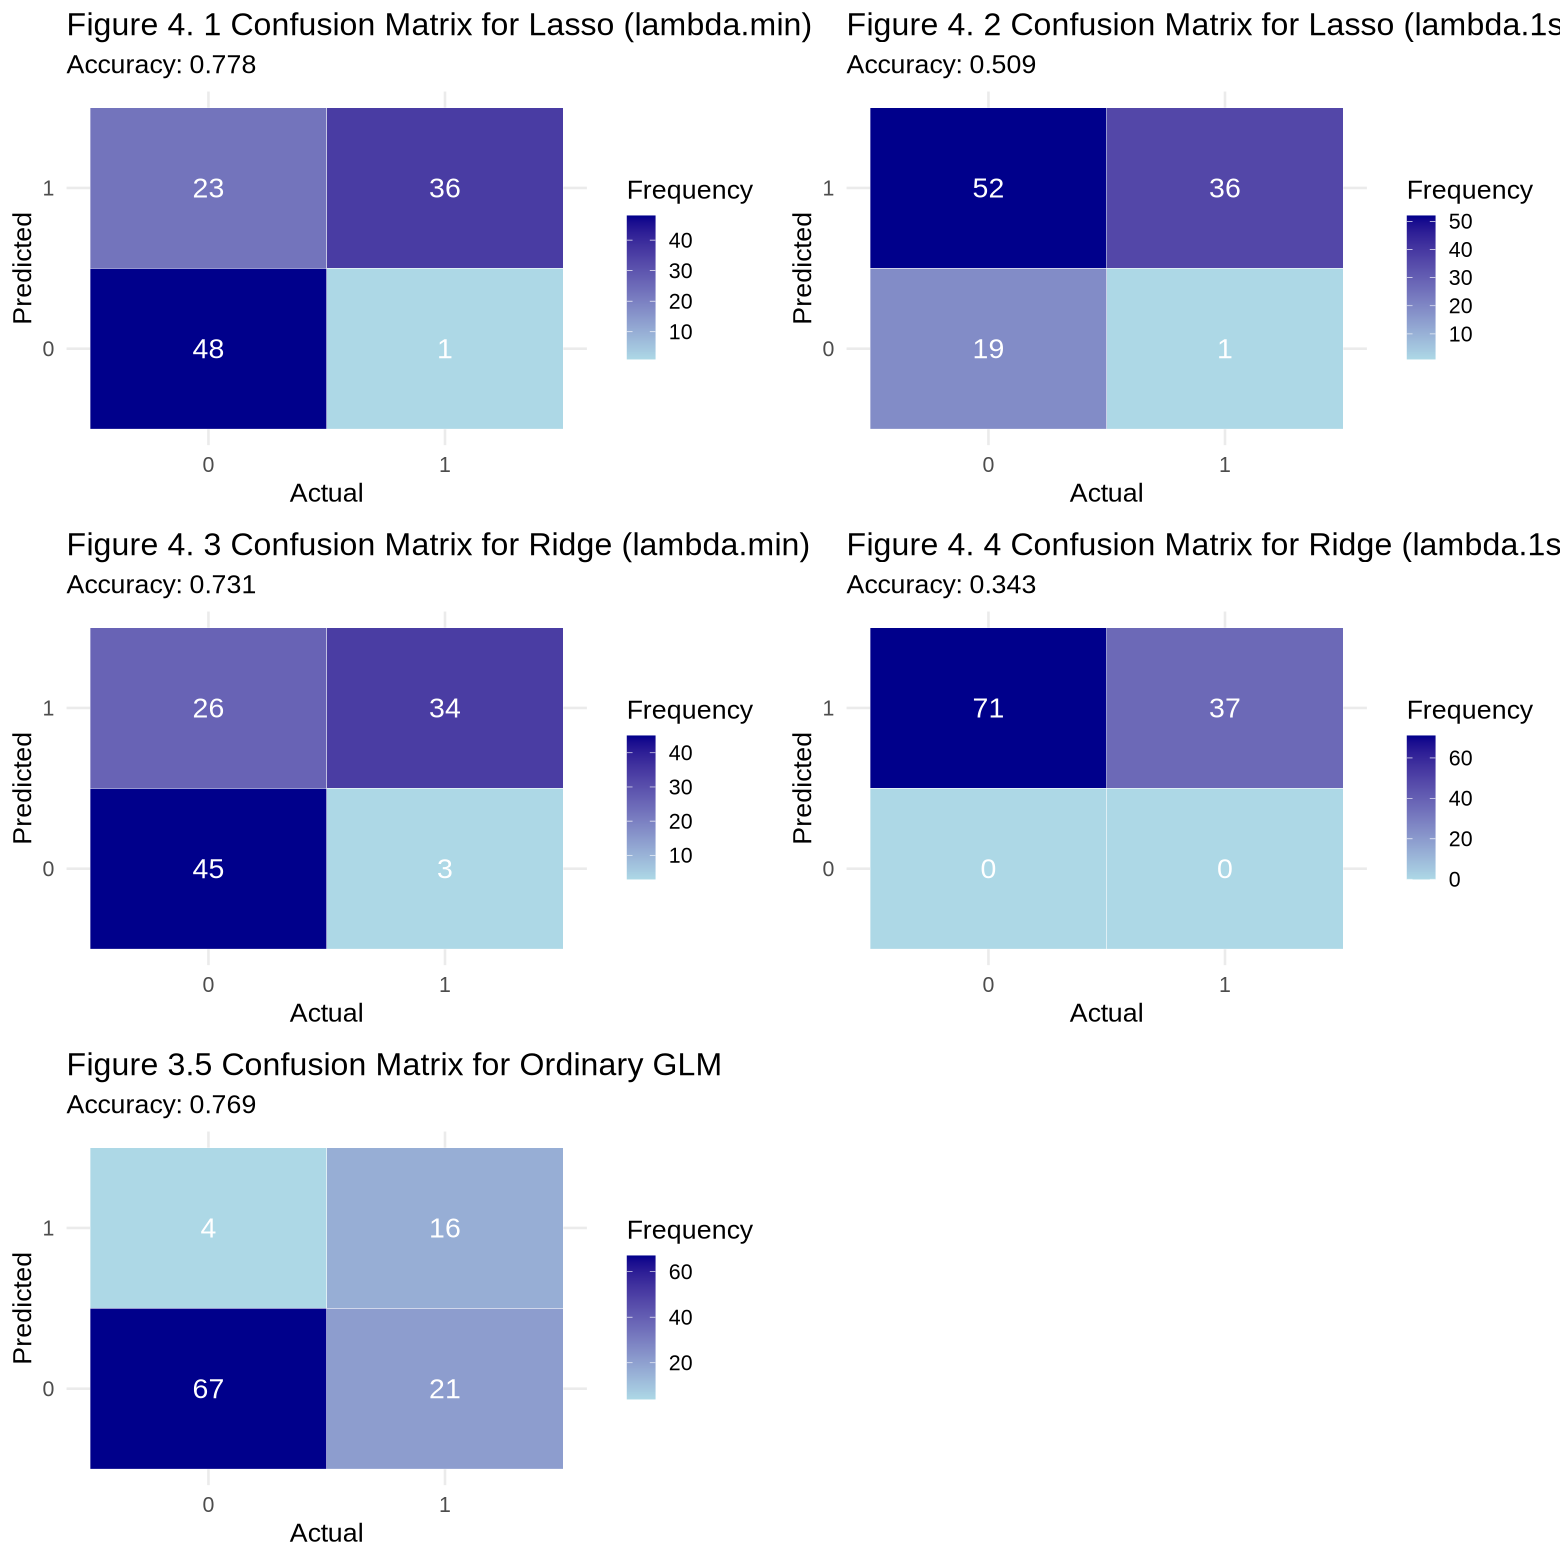

In [430]:
#Main Author : Josh
#Making confusion matricies and testing accuracy for models
models <- list(
  diabetes_LASSO_max_AUC,
  diabetes_LASSO_1se_AUC,
  diabetes_ridge_max_AUC,
  diabetes_ridge_1se_AUC

)

model_names <- c(
  "Lasso (lambda.min)",
  "Lasso (lambda.1se)",
  "Ridge (lambda.min)",
  "Ridge (lambda.1se)"

)
plts <- list()
p_val <- 0.5
#for al lasso and ridge models
options(repr.plot.width = 13, repr.plot.height = 13)
for (i in seq_along(models)) {
  model <- models[[i]]
  model_name <- model_names[i]
  
  predicted_vals <- predict(model, newx = diabetes_X_test, type = "response")
  fitted_values <- ifelse(predicted_vals > p_val, 1, 0)
  accuracy <- mean(fitted_values == testing_diabetes$Outcome)

  confusion_m <- table(
    Predicted = factor(fitted_values, levels = c(0, 1)),
    Actual = factor(testing_diabetes$Outcome, levels = c(0, 1))
  )

  confusion_m_df <- as.data.frame(confusion_m)
  colnames(confusion_m_df) <- c("Predicted", "Actual", "Frequency")
  
  plot <- ggplot(confusion_m_df, aes(x = Actual, y = Predicted, fill = Frequency)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Frequency), color = "white", size = 6) +
    scale_fill_gradient(low = "lightblue", high = "darkblue") +
    labs(
      title = paste("Figure 4.",i,"Confusion Matrix for", model_name),
      subtitle = paste("Accuracy:", round(accuracy, 3)),  
      x = "Actual",
      y = "Predicted"
    ) +
    theme_minimal(base_size = 16)
    plts[[i]] <- plot
  
}



#ordinary glm matrix
predicted <- predict(diabetes_logistic_model,newdata = testing_diabetes)
  fitted <- ifelse(predicted > p_val, 1, 0)
  accuracy <- mean(fitted == testing_diabetes$Outcome)
  confusion_m <- table(
    Predicted = factor(fitted, levels = c(0, 1)),
    Actual = factor(testing_diabetes$Outcome, levels = c(0, 1))
  )

  confusion_m_df <- as.data.frame(confusion_m)
  colnames(confusion_m_df) <- c("Predicted", "Actual", "Frequency")
  glm_plt <- ggplot(confusion_m_df, aes(x = Actual, y = Predicted, fill = Frequency)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Frequency), color = "white", size = 6) +
    scale_fill_gradient(low = "lightblue", high = "darkblue") +
    labs(
      title = paste("Figure 3.5 Confusion Matrix for Ordinary GLM"),
      subtitle = paste("Accuracy:", round(accuracy, 3)),  
      x = "Actual",
      y = "Predicted"
    ) +
    theme_minimal(base_size = 16)
    plts[[5]] <- glm_plt


do.call(grid.arrange,plts)

In [427]:
set.seed(123)
misclassification_rate <- function(y, p.hat){
    y_hat <- round(p.hat, 0)
    error_rate <- mean(abs(y - y_hat))
    return(error_rate)
}


error_rate_train <- 
    misclassification_rate(
        as.numeric(testing_diabetes$Outcome)-1,
        predict(diabetes_logistic_model,newdata = testing_diabetes, type = "response"))
error_rate_train

cv_logistic <- 
    cv.glm(
        glmfit = diabetes_logistic_model, 
        data = testing_diabetes, 
        K = 10, cost = misclassification_rate
    )
cv_logistic$delta[1]


pred_class <- 
  round(predict(diabetes_logistic_model,newdata =testing_diabetes,  type = "response"), 0)

diabetes_glm_con <- 
    confusionMatrix(
    data = as.factor(pred_class),
    reference = as.factor(testing_diabetes$Outcome),
    positive = '1'
)

diabetes_glm_con

[1] 0.2314815

[1] 0.4814815

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 65 19
         1  6 18
                                          
               Accuracy : 0.7685          
                 95% CI : (0.6775, 0.8443)
    No Information Rate : 0.6574          
    P-Value [Acc > NIR] : 0.008372        
                                          
                  Kappa : 0.4389          
                                          
 Mcnemar's Test P-Value : 0.016395        
                                          
            Sensitivity : 0.4865          
            Specificity : 0.9155          
         Pos Pred Value : 0.7500          
         Neg Pred Value : 0.7738          
             Prevalence : 0.3426          
         Detection Rate : 0.1667          
   Detection Prevalence : 0.2222          
      Balanced Accuracy : 0.7010          
                                          
       'Positive' Class : 1               
                                    

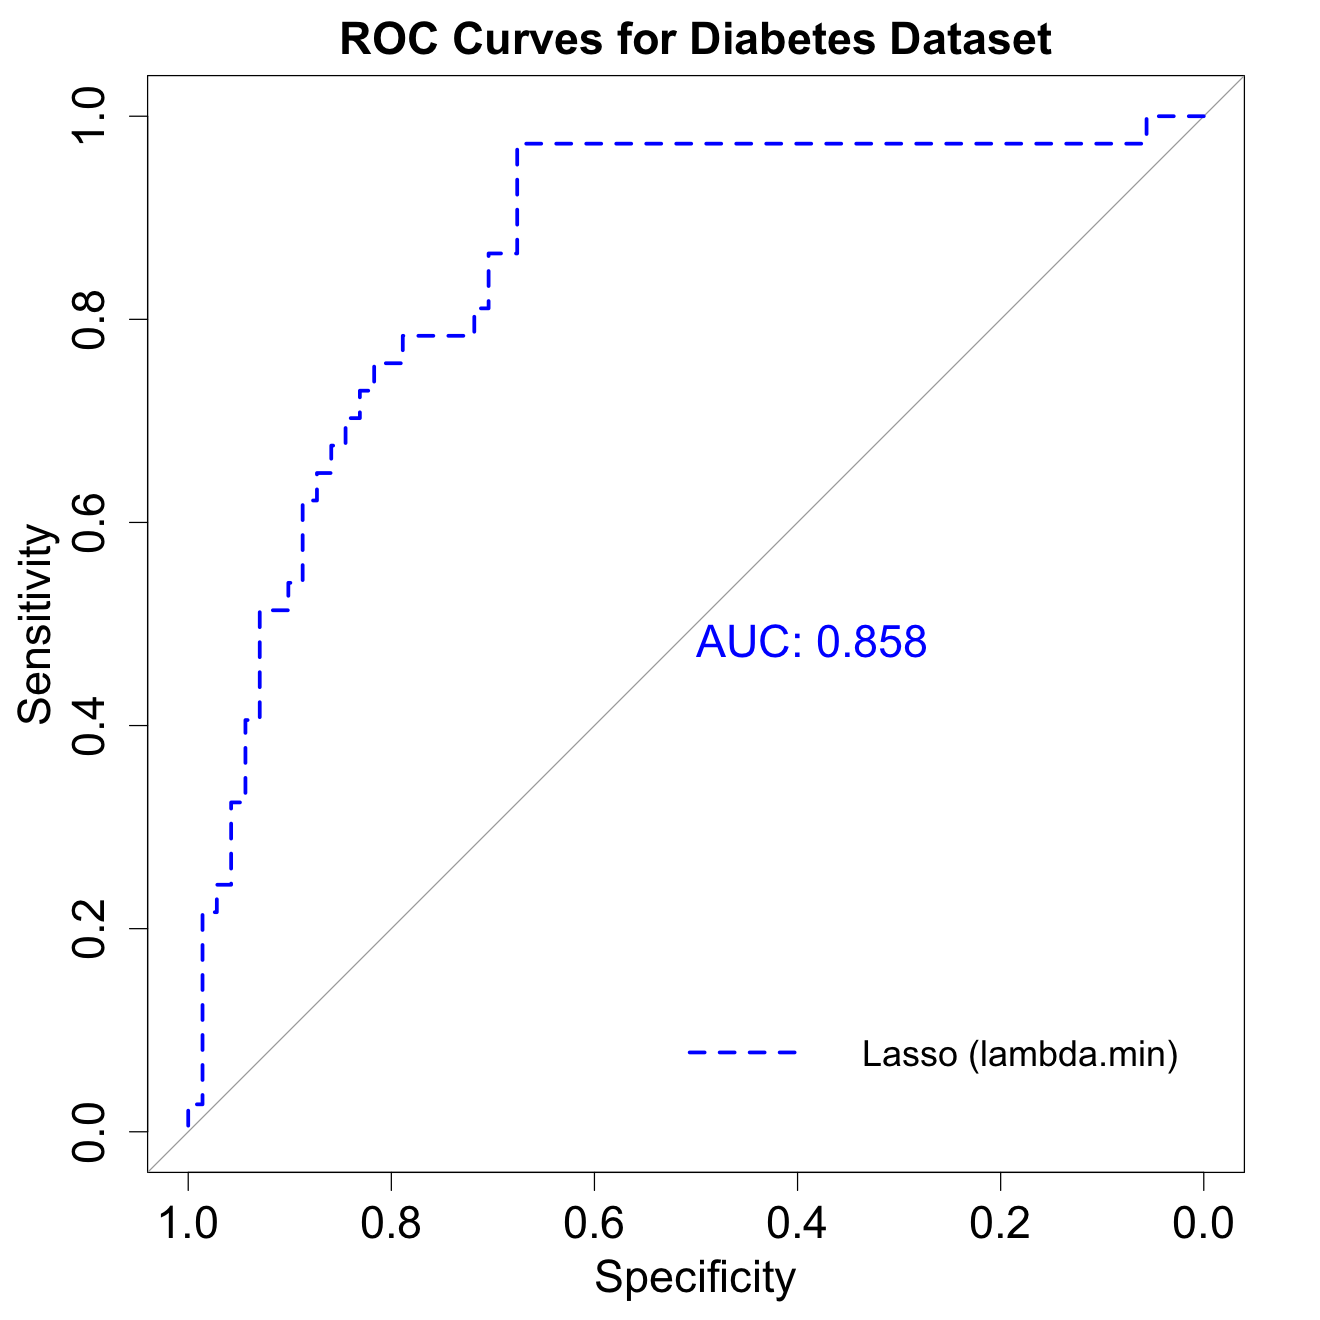

In [24]:
# Main developer: Yulin 

options(repr.plot.width = 11, repr.plot.height = 11) 
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

plot(ROC_lasso_lambda_min,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes Dataset"
)

par(fig = c(0, 1, 0, 1), new = TRUE)
plot.new()
legend(x = "bottomright", inset = c(-0.2, 0), legend = "Lasso (lambda.min)",
       col = "blue", 
       lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

In [396]:
# Main developer: Yulin 

# options(repr.plot.width = 11, repr.plot.height = 11) 
# par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

# plot(ROC_lasso_lambda_min,
#   print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
#   main = "ROC Curves for Diabetes Dataset"
# )

# par(fig = c(0, 1, 0, 1), new = TRUE)
# plot.new()
# legend(x = "bottomright", inset = c(-0.2, 0), legend = "Lasso (lambda.min)",
#        col = "blue", 
#        lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

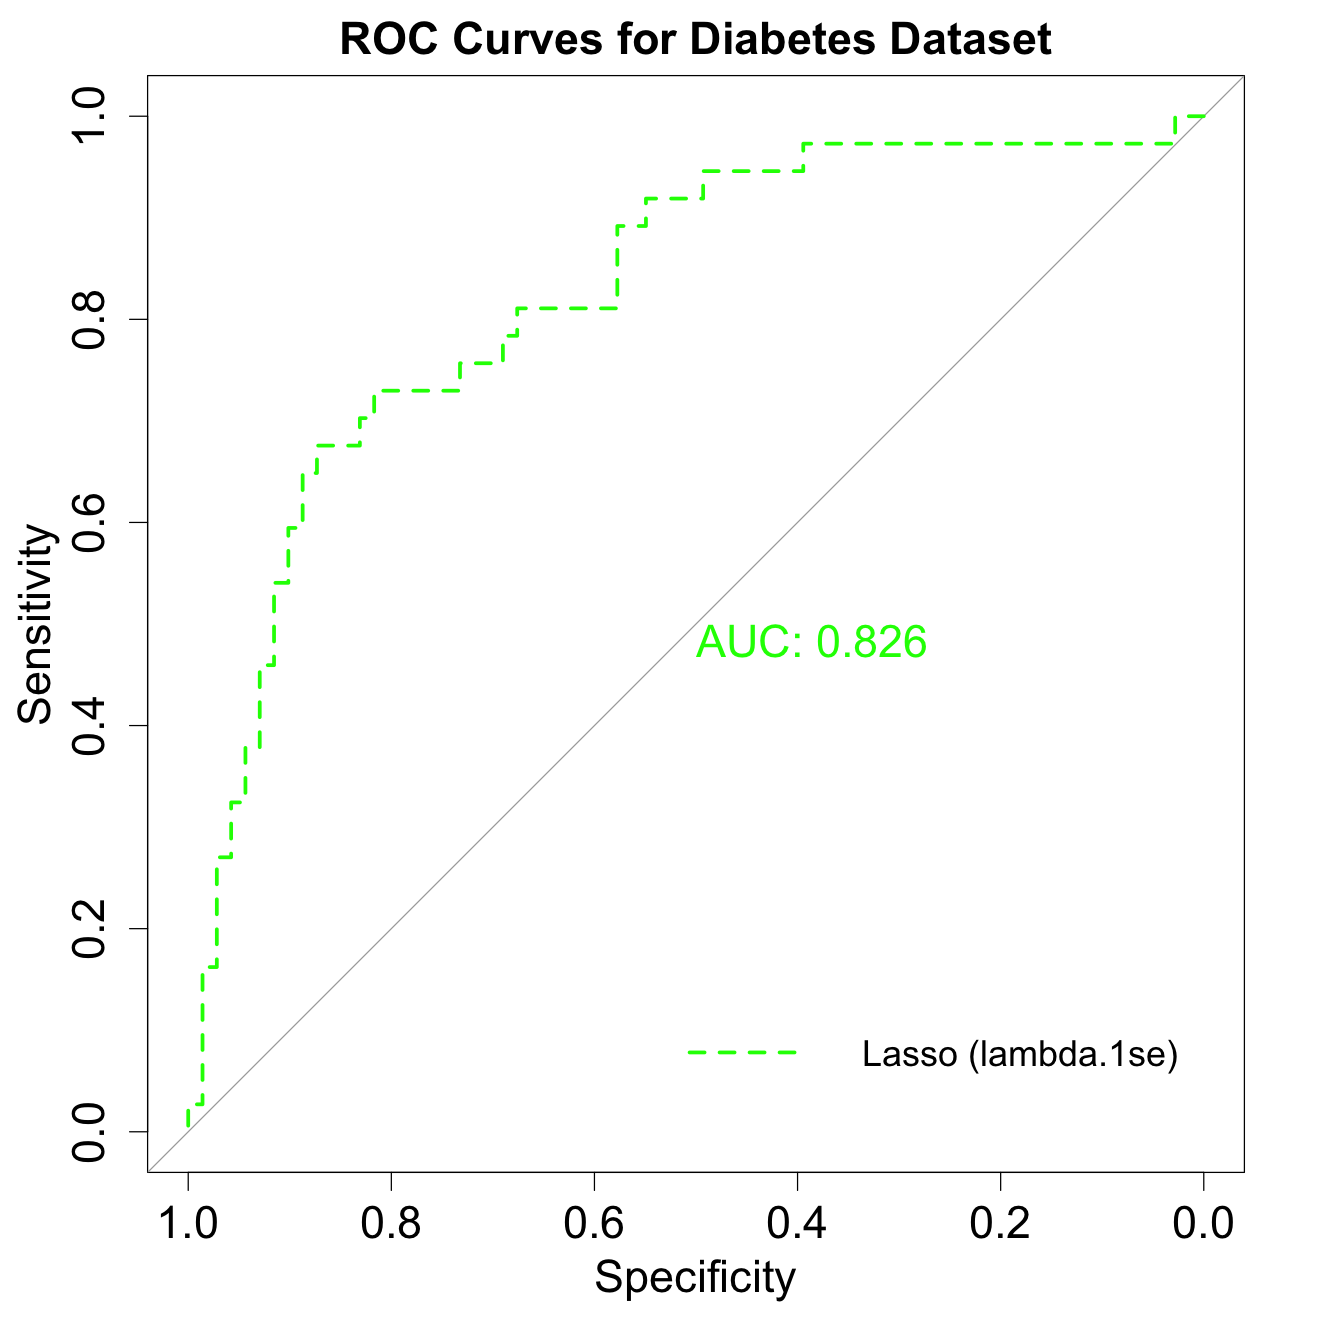

In [25]:
# Main developer: Yulin 

options(repr.plot.width = 11, repr.plot.height = 11) 
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

plot(ROC_lasso_lambda_1se,
  print.auc = TRUE, col = "green", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes Dataset"
)

par(fig = c(0, 1, 0, 1), new = TRUE)
plot.new()
legend(x = "bottomright", inset = c(-0.2, 0), legend = "Lasso (lambda.1se)",
       col = "green", 
       lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

In [208]:
# Main developer: Yulin 

# options(repr.plot.width = 11, repr.plot.height = 11) 
# par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

# plot(ROC_lasso_lambda_1se,
#   print.auc = TRUE, col = "green", lwd = 3, lty = 2,
#   main = "ROC Curves for Diabetes Dataset"
# )

# par(fig = c(0, 1, 0, 1), new = TRUE)
# plot.new()
# legend(x = "bottomright", inset = c(-0.2, 0), legend = "Lasso (lambda.1se)",
#        col = "green", 
#        lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

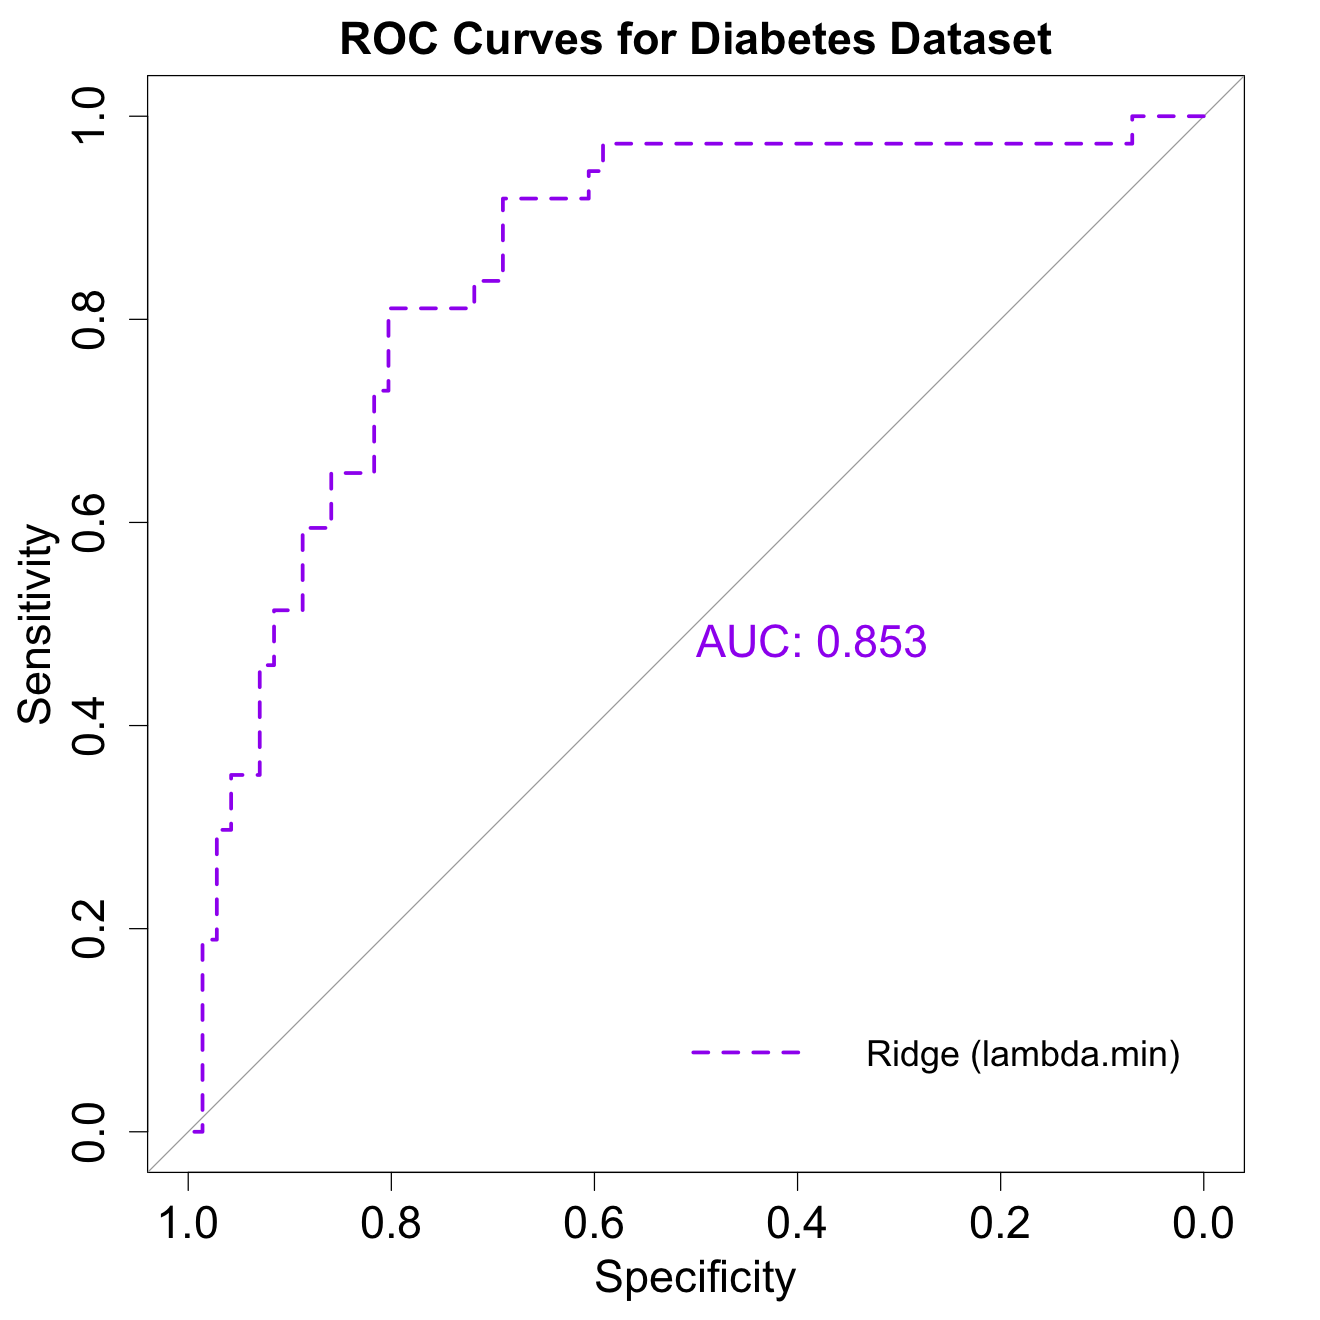

In [26]:
# Main developer: Yulin 

options(repr.plot.width = 11, repr.plot.height = 11) 
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

plot(ROC_ridge_lambda_min,
  print.auc = TRUE, col = "purple", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes Dataset"
)

par(fig = c(0, 1, 0, 1), new = TRUE)
plot.new()
legend(x = "bottomright", inset = c(-0.2, 0), legend = "Ridge (lambda.min)",
       col = "purple", 
       lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

In [209]:
# Main developer: Yulin 

# options(repr.plot.width = 11, repr.plot.height = 11) 
# par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

# plot(ROC_ridge_lambda_min,
#   print.auc = TRUE, col = "purple", lwd = 3, lty = 2,
#   main = "ROC Curves for Diabetes Dataset"
# )

# par(fig = c(0, 1, 0, 1), new = TRUE)
# plot.new()
# legend(x = "bottomright", inset = c(-0.2, 0), legend = "Ridge (lambda.min)",
#        col = "purple", 
#        lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

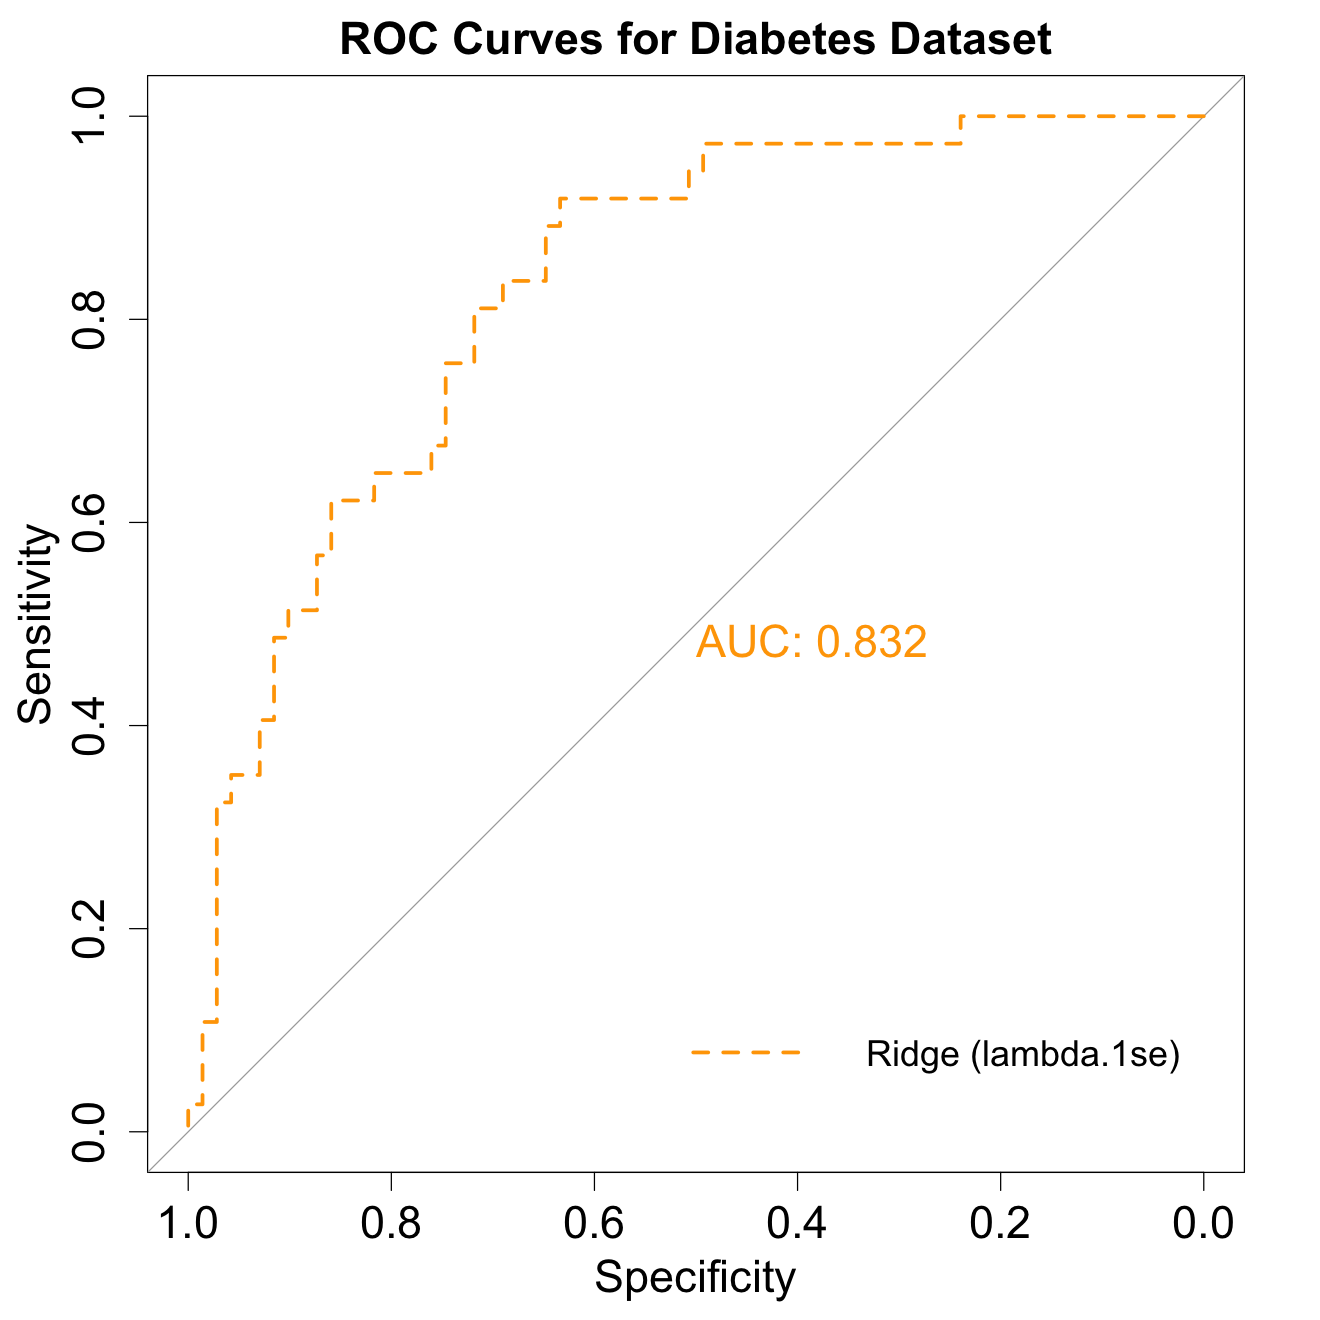

In [ ]:
options(repr.plot.width = 11, repr.plot.height = 11) 
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

plot(ROC_lasso_lambda_min,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes Dataset"
)

par(fig = c(0, 1, 0, 1), new = TRUE)
plot.new()
legend(x = "bottomright", inset = c(-0.2, 0), legend = "Lasso (lambda.min)",
       col = "blue", 
       lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

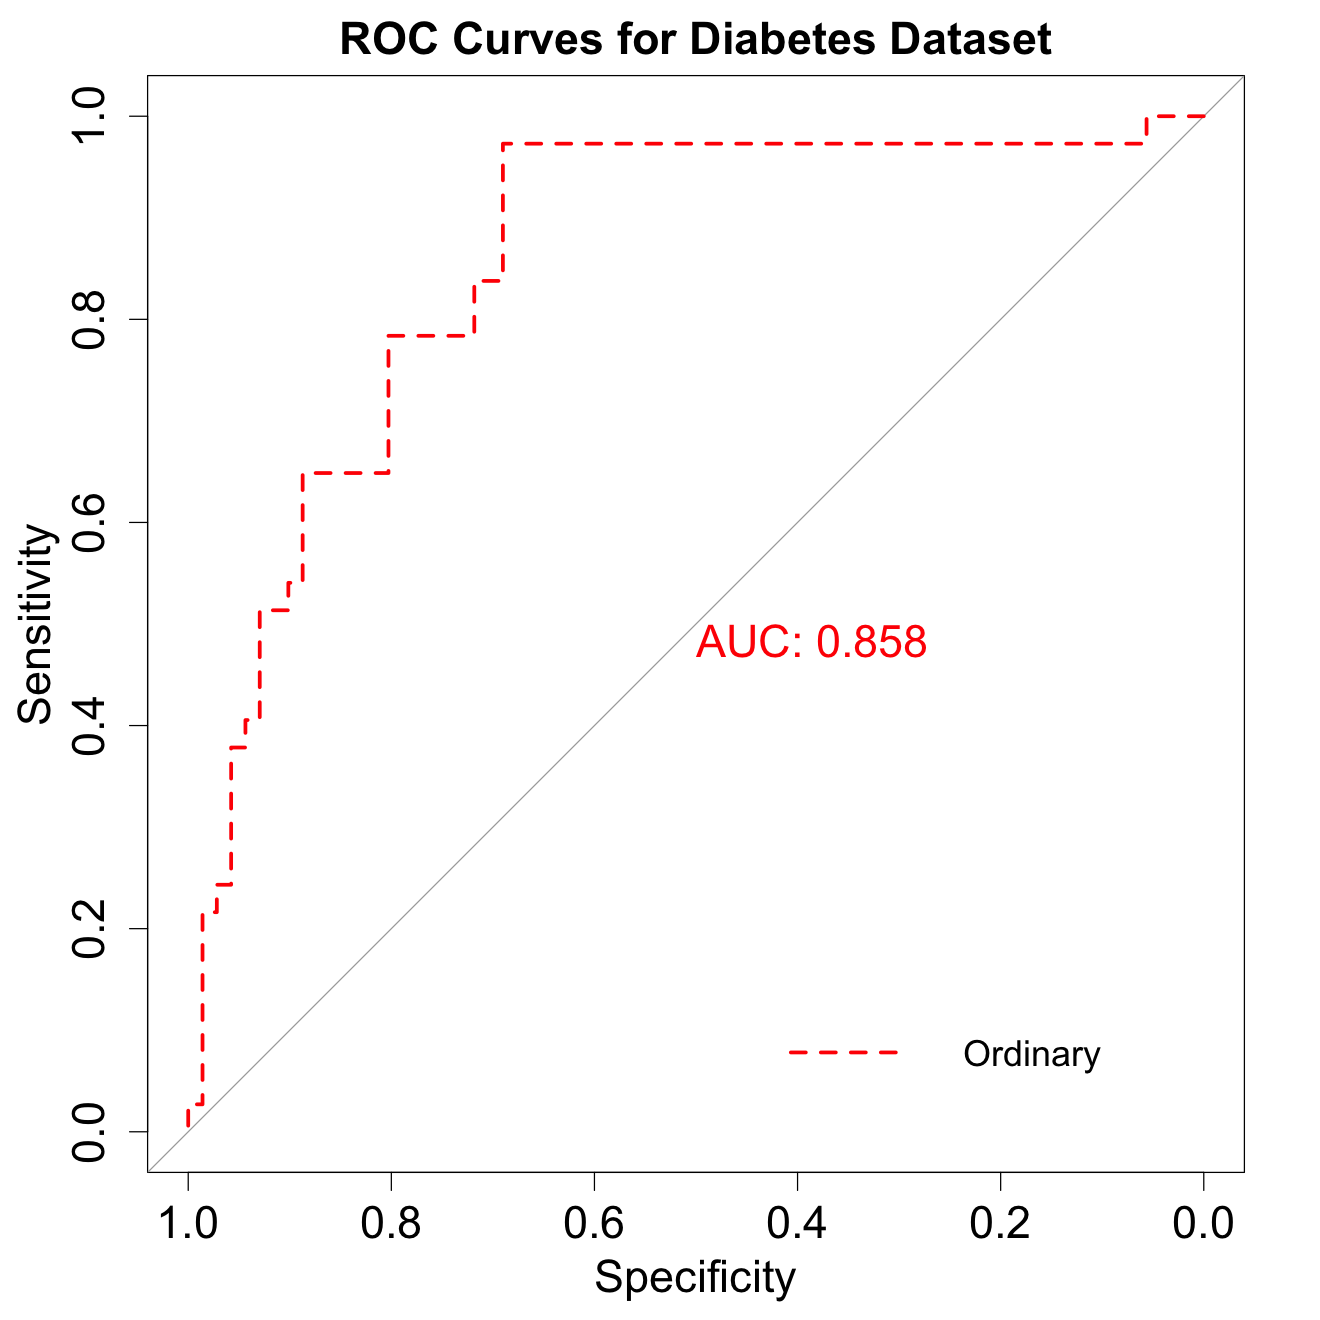

In [ ]:
options(repr.plot.width = 11, repr.plot.height = 11) 
par(cex = 1.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5)

plot(ROC_lasso_lambda_1se,
  print.auc = TRUE, col = "green", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes Dataset"
)

par(fig = c(0, 1, 0, 1), new = TRUE)
plot.new()
legend(x = "bottomright", inset = c(-0.2, 0), legend = "Lasso (lambda.1se)",
       col = "green", 
       lwd = 3, lty = 2, bty = "n", cex = 1.2, xpd = TRUE)

# Discussion

# References